In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "fsv3"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 297
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 369
Categorical Columns: 8


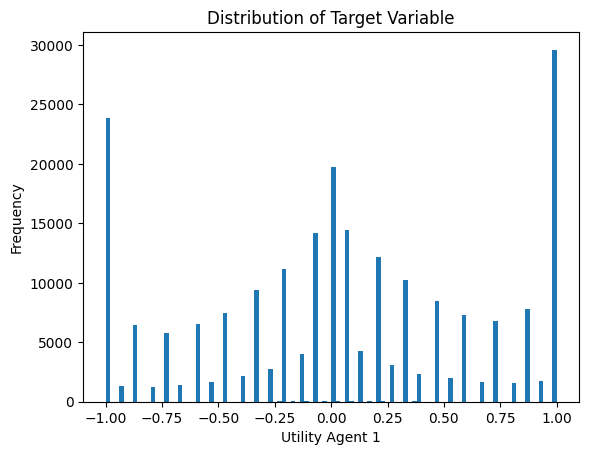

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6124870	test: 0.5521215	best: 0.5521215 (0)	total: 159ms	remaining: 7m 56s


50:	learn: 0.3801426	test: 0.4645768	best: 0.4645768 (50)	total: 4.54s	remaining: 4m 22s


100:	learn: 0.3413272	test: 0.4493869	best: 0.4493869 (100)	total: 9.27s	remaining: 4m 26s


150:	learn: 0.3197775	test: 0.4426832	best: 0.4426832 (150)	total: 14.7s	remaining: 4m 38s


200:	learn: 0.3043554	test: 0.4391414	best: 0.4391414 (200)	total: 19.6s	remaining: 4m 32s


250:	learn: 0.2932777	test: 0.4366920	best: 0.4366553 (249)	total: 24.3s	remaining: 4m 26s


300:	learn: 0.2842677	test: 0.4350609	best: 0.4350609 (300)	total: 29.3s	remaining: 4m 22s


350:	learn: 0.2761076	test: 0.4333214	best: 0.4333038 (349)	total: 34.1s	remaining: 4m 17s


400:	learn: 0.2699608	test: 0.4319880	best: 0.4319791 (399)	total: 39s	remaining: 4m 12s


450:	learn: 0.2648375	test: 0.4310479	best: 0.4310479 (450)	total: 43.9s	remaining: 4m 8s


500:	learn: 0.2598111	test: 0.4306085	best: 0.4305775 (497)	total: 48.7s	remaining: 4m 2s


550:	learn: 0.2549923	test: 0.4302548	best: 0.4302478 (549)	total: 53.5s	remaining: 3m 57s


600:	learn: 0.2509174	test: 0.4298620	best: 0.4298615 (599)	total: 58.4s	remaining: 3m 53s


650:	learn: 0.2468403	test: 0.4293048	best: 0.4293048 (650)	total: 1m 3s	remaining: 3m 48s


700:	learn: 0.2431170	test: 0.4287677	best: 0.4287222 (697)	total: 1m 8s	remaining: 3m 43s


750:	learn: 0.2397881	test: 0.4285358	best: 0.4285074 (741)	total: 1m 13s	remaining: 3m 38s


800:	learn: 0.2367444	test: 0.4284361	best: 0.4284076 (787)	total: 1m 17s	remaining: 3m 33s


850:	learn: 0.2341699	test: 0.4282937	best: 0.4282316 (840)	total: 1m 22s	remaining: 3m 29s


900:	learn: 0.2315513	test: 0.4282054	best: 0.4282054 (900)	total: 1m 27s	remaining: 3m 24s


950:	learn: 0.2287426	test: 0.4278292	best: 0.4278292 (950)	total: 1m 32s	remaining: 3m 19s


1000:	learn: 0.2264098	test: 0.4277336	best: 0.4277287 (981)	total: 1m 37s	remaining: 3m 14s


1050:	learn: 0.2239684	test: 0.4275139	best: 0.4274949 (1046)	total: 1m 42s	remaining: 3m 9s


1100:	learn: 0.2217497	test: 0.4276737	best: 0.4274949 (1046)	total: 1m 47s	remaining: 3m 4s


1150:	learn: 0.2193670	test: 0.4275165	best: 0.4274646 (1148)	total: 1m 52s	remaining: 2m 59s


1200:	learn: 0.2172501	test: 0.4272990	best: 0.4272463 (1192)	total: 1m 56s	remaining: 2m 55s


1250:	learn: 0.2152915	test: 0.4273519	best: 0.4272463 (1192)	total: 2m 1s	remaining: 2m 50s


1300:	learn: 0.2136772	test: 0.4273639	best: 0.4272463 (1192)	total: 2m 6s	remaining: 2m 45s


1350:	learn: 0.2120292	test: 0.4273545	best: 0.4272463 (1192)	total: 2m 11s	remaining: 2m 40s


1400:	learn: 0.2101162	test: 0.4273569	best: 0.4272463 (1192)	total: 2m 16s	remaining: 2m 35s


1450:	learn: 0.2084929	test: 0.4274336	best: 0.4272463 (1192)	total: 2m 21s	remaining: 2m 31s


1500:	learn: 0.2069597	test: 0.4273390	best: 0.4272463 (1192)	total: 2m 26s	remaining: 2m 26s


1550:	learn: 0.2052238	test: 0.4270903	best: 0.4270903 (1550)	total: 2m 31s	remaining: 2m 21s


1600:	learn: 0.2036941	test: 0.4271223	best: 0.4270659 (1555)	total: 2m 36s	remaining: 2m 16s


1650:	learn: 0.2021386	test: 0.4271361	best: 0.4270659 (1555)	total: 2m 41s	remaining: 2m 11s


1700:	learn: 0.2006017	test: 0.4271401	best: 0.4270659 (1555)	total: 2m 46s	remaining: 2m 6s


1750:	learn: 0.1990254	test: 0.4271606	best: 0.4270659 (1555)	total: 2m 51s	remaining: 2m 2s


1800:	learn: 0.1976188	test: 0.4272025	best: 0.4270659 (1555)	total: 2m 56s	remaining: 1m 57s


1850:	learn: 0.1960791	test: 0.4271631	best: 0.4270659 (1555)	total: 3m 1s	remaining: 1m 52s


1900:	learn: 0.1947547	test: 0.4271625	best: 0.4270659 (1555)	total: 3m 6s	remaining: 1m 47s


1950:	learn: 0.1934378	test: 0.4272431	best: 0.4270659 (1555)	total: 3m 11s	remaining: 1m 42s


2000:	learn: 0.1920764	test: 0.4271742	best: 0.4270659 (1555)	total: 3m 16s	remaining: 1m 37s


2050:	learn: 0.1907031	test: 0.4272109	best: 0.4270659 (1555)	total: 3m 20s	remaining: 1m 32s


2100:	learn: 0.1893190	test: 0.4272440	best: 0.4270659 (1555)	total: 3m 25s	remaining: 1m 28s


2150:	learn: 0.1880058	test: 0.4272674	best: 0.4270659 (1555)	total: 3m 30s	remaining: 1m 23s


2200:	learn: 0.1867099	test: 0.4272008	best: 0.4270659 (1555)	total: 3m 35s	remaining: 1m 18s


2250:	learn: 0.1855169	test: 0.4271288	best: 0.4270659 (1555)	total: 3m 40s	remaining: 1m 13s


2300:	learn: 0.1841927	test: 0.4271015	best: 0.4270659 (1555)	total: 3m 45s	remaining: 1m 8s


2350:	learn: 0.1829884	test: 0.4271011	best: 0.4270659 (1555)	total: 3m 50s	remaining: 1m 3s


2400:	learn: 0.1818457	test: 0.4271468	best: 0.4270659 (1555)	total: 3m 55s	remaining: 58.7s


2450:	learn: 0.1806040	test: 0.4271695	best: 0.4270659 (1555)	total: 4m	remaining: 53.8s


2500:	learn: 0.1795468	test: 0.4271177	best: 0.4270659 (1555)	total: 4m 5s	remaining: 48.9s


2550:	learn: 0.1782982	test: 0.4271650	best: 0.4270659 (1555)	total: 4m 10s	remaining: 44s


2600:	learn: 0.1771484	test: 0.4271193	best: 0.4270659 (1555)	total: 4m 14s	remaining: 39.1s


2650:	learn: 0.1760225	test: 0.4271121	best: 0.4270659 (1555)	total: 4m 19s	remaining: 34.2s


2700:	learn: 0.1749514	test: 0.4270754	best: 0.4270659 (1555)	total: 4m 24s	remaining: 29.3s


2750:	learn: 0.1739958	test: 0.4270819	best: 0.4270543 (2734)	total: 4m 29s	remaining: 24.4s


2800:	learn: 0.1729843	test: 0.4271100	best: 0.4270543 (2734)	total: 4m 34s	remaining: 19.5s


2850:	learn: 0.1720027	test: 0.4271653	best: 0.4270543 (2734)	total: 4m 39s	remaining: 14.6s


2900:	learn: 0.1709324	test: 0.4271665	best: 0.4270543 (2734)	total: 4m 44s	remaining: 9.72s


2950:	learn: 0.1699571	test: 0.4271325	best: 0.4270543 (2734)	total: 4m 49s	remaining: 4.81s


2999:	learn: 0.1688837	test: 0.4271549	best: 0.4270543 (2734)	total: 4m 54s	remaining: 0us

bestTest = 0.4270543053
bestIteration = 2734

Shrink model to first 2735 iterations.


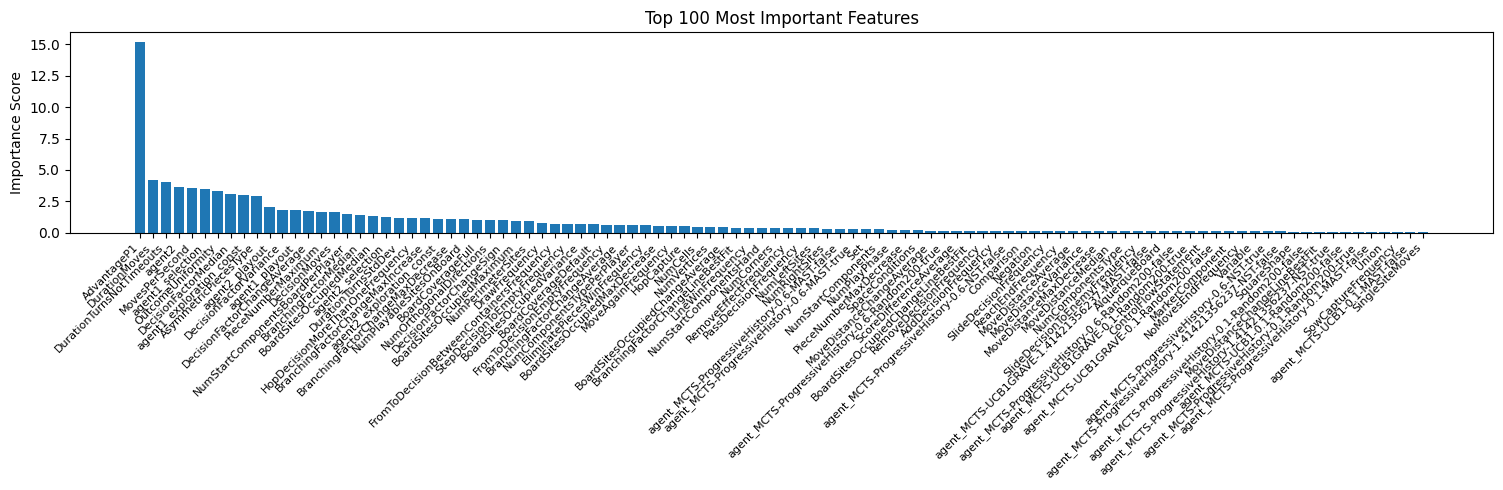

Fold 1 - RMSE: 0.4266371835870971
Fold 2


0:	learn: 0.6066013	test: 0.5792494	best: 0.5792494 (0)	total: 89.2ms	remaining: 4m 27s


50:	learn: 0.3852216	test: 0.4727102	best: 0.4727102 (50)	total: 4.83s	remaining: 4m 39s


100:	learn: 0.3482228	test: 0.4585040	best: 0.4585040 (100)	total: 9.88s	remaining: 4m 43s


150:	learn: 0.3270183	test: 0.4527770	best: 0.4526464 (148)	total: 14.9s	remaining: 4m 41s


200:	learn: 0.3128748	test: 0.4495070	best: 0.4495070 (200)	total: 19.9s	remaining: 4m 37s


250:	learn: 0.3014006	test: 0.4476441	best: 0.4476251 (247)	total: 25s	remaining: 4m 33s


300:	learn: 0.2923572	test: 0.4463887	best: 0.4463887 (300)	total: 30s	remaining: 4m 28s


350:	learn: 0.2847563	test: 0.4448371	best: 0.4448371 (350)	total: 35s	remaining: 4m 24s


400:	learn: 0.2786007	test: 0.4435665	best: 0.4435665 (400)	total: 40.1s	remaining: 4m 20s


450:	learn: 0.2728871	test: 0.4427520	best: 0.4427520 (450)	total: 45.3s	remaining: 4m 15s


500:	learn: 0.2679585	test: 0.4423477	best: 0.4423477 (500)	total: 50.4s	remaining: 4m 11s


550:	learn: 0.2630855	test: 0.4416559	best: 0.4416559 (550)	total: 55.6s	remaining: 4m 7s


600:	learn: 0.2583089	test: 0.4410732	best: 0.4410718 (599)	total: 1m	remaining: 4m 2s


650:	learn: 0.2545418	test: 0.4405896	best: 0.4405896 (650)	total: 1m 5s	remaining: 3m 57s


700:	learn: 0.2507340	test: 0.4402060	best: 0.4402060 (700)	total: 1m 11s	remaining: 3m 53s


750:	learn: 0.2474473	test: 0.4397958	best: 0.4397958 (750)	total: 1m 16s	remaining: 3m 49s


800:	learn: 0.2443793	test: 0.4397317	best: 0.4395824 (789)	total: 1m 21s	remaining: 3m 44s


850:	learn: 0.2414802	test: 0.4396287	best: 0.4395824 (789)	total: 1m 26s	remaining: 3m 39s


900:	learn: 0.2386157	test: 0.4394656	best: 0.4394269 (898)	total: 1m 32s	remaining: 3m 34s


950:	learn: 0.2361109	test: 0.4394226	best: 0.4394116 (948)	total: 1m 37s	remaining: 3m 29s


1000:	learn: 0.2337211	test: 0.4391825	best: 0.4391645 (996)	total: 1m 42s	remaining: 3m 25s


1050:	learn: 0.2311403	test: 0.4390177	best: 0.4390177 (1050)	total: 1m 47s	remaining: 3m 20s


1100:	learn: 0.2287851	test: 0.4389686	best: 0.4389203 (1090)	total: 1m 53s	remaining: 3m 15s


1150:	learn: 0.2266341	test: 0.4386233	best: 0.4385928 (1143)	total: 1m 58s	remaining: 3m 10s


1200:	learn: 0.2246696	test: 0.4384978	best: 0.4384809 (1179)	total: 2m 3s	remaining: 3m 5s


1250:	learn: 0.2227080	test: 0.4383562	best: 0.4383292 (1245)	total: 2m 9s	remaining: 3m


1300:	learn: 0.2206668	test: 0.4381980	best: 0.4381503 (1280)	total: 2m 14s	remaining: 2m 55s


1350:	learn: 0.2186304	test: 0.4381425	best: 0.4380339 (1340)	total: 2m 19s	remaining: 2m 50s


1400:	learn: 0.2167683	test: 0.4380529	best: 0.4380339 (1340)	total: 2m 24s	remaining: 2m 45s


1450:	learn: 0.2147947	test: 0.4380628	best: 0.4380074 (1437)	total: 2m 30s	remaining: 2m 40s


1500:	learn: 0.2130571	test: 0.4380088	best: 0.4379621 (1473)	total: 2m 35s	remaining: 2m 35s


1550:	learn: 0.2112696	test: 0.4379829	best: 0.4379621 (1473)	total: 2m 40s	remaining: 2m 29s


1600:	learn: 0.2094860	test: 0.4378098	best: 0.4378057 (1589)	total: 2m 45s	remaining: 2m 24s


1650:	learn: 0.2079203	test: 0.4377057	best: 0.4376943 (1645)	total: 2m 50s	remaining: 2m 19s


1700:	learn: 0.2064626	test: 0.4375939	best: 0.4375939 (1700)	total: 2m 56s	remaining: 2m 14s


1750:	learn: 0.2049116	test: 0.4375053	best: 0.4375004 (1749)	total: 3m 1s	remaining: 2m 9s


1800:	learn: 0.2035400	test: 0.4373813	best: 0.4373813 (1800)	total: 3m 6s	remaining: 2m 4s


1850:	learn: 0.2019374	test: 0.4372128	best: 0.4372092 (1848)	total: 3m 11s	remaining: 1m 59s


1900:	learn: 0.2005253	test: 0.4370996	best: 0.4370996 (1900)	total: 3m 17s	remaining: 1m 53s


1950:	learn: 0.1991443	test: 0.4369732	best: 0.4369732 (1950)	total: 3m 22s	remaining: 1m 48s


2000:	learn: 0.1978475	test: 0.4369211	best: 0.4369186 (1999)	total: 3m 27s	remaining: 1m 43s


2050:	learn: 0.1965570	test: 0.4369277	best: 0.4368864 (2040)	total: 3m 32s	remaining: 1m 38s


2100:	learn: 0.1952292	test: 0.4368603	best: 0.4368428 (2093)	total: 3m 37s	remaining: 1m 33s


2150:	learn: 0.1939733	test: 0.4367803	best: 0.4367704 (2147)	total: 3m 43s	remaining: 1m 28s


2200:	learn: 0.1926300	test: 0.4367553	best: 0.4367206 (2180)	total: 3m 48s	remaining: 1m 22s


2250:	learn: 0.1913520	test: 0.4367389	best: 0.4367206 (2180)	total: 3m 53s	remaining: 1m 17s


2300:	learn: 0.1901721	test: 0.4367335	best: 0.4367130 (2273)	total: 3m 58s	remaining: 1m 12s


2350:	learn: 0.1890044	test: 0.4366871	best: 0.4366824 (2349)	total: 4m 3s	remaining: 1m 7s


2400:	learn: 0.1878400	test: 0.4367166	best: 0.4366824 (2349)	total: 4m 8s	remaining: 1m 2s


2450:	learn: 0.1866950	test: 0.4367661	best: 0.4366824 (2349)	total: 4m 14s	remaining: 56.9s


2500:	learn: 0.1854585	test: 0.4367584	best: 0.4366824 (2349)	total: 4m 19s	remaining: 51.7s


2550:	learn: 0.1843980	test: 0.4367423	best: 0.4366824 (2349)	total: 4m 24s	remaining: 46.5s


2600:	learn: 0.1833693	test: 0.4367194	best: 0.4366824 (2349)	total: 4m 29s	remaining: 41.4s


2650:	learn: 0.1822054	test: 0.4367054	best: 0.4366824 (2349)	total: 4m 34s	remaining: 36.2s


2700:	learn: 0.1810981	test: 0.4366644	best: 0.4366552 (2677)	total: 4m 39s	remaining: 31s


2750:	learn: 0.1800753	test: 0.4366593	best: 0.4366487 (2749)	total: 4m 45s	remaining: 25.8s


2800:	learn: 0.1790960	test: 0.4366596	best: 0.4366349 (2772)	total: 4m 50s	remaining: 20.6s


2850:	learn: 0.1780909	test: 0.4366511	best: 0.4366327 (2805)	total: 4m 55s	remaining: 15.4s


2900:	learn: 0.1769634	test: 0.4366007	best: 0.4365916 (2894)	total: 5m	remaining: 10.3s


2950:	learn: 0.1758982	test: 0.4365296	best: 0.4365296 (2950)	total: 5m 5s	remaining: 5.08s


2999:	learn: 0.1750095	test: 0.4365214	best: 0.4365214 (2999)	total: 5m 10s	remaining: 0us

bestTest = 0.4365214131
bestIteration = 2999



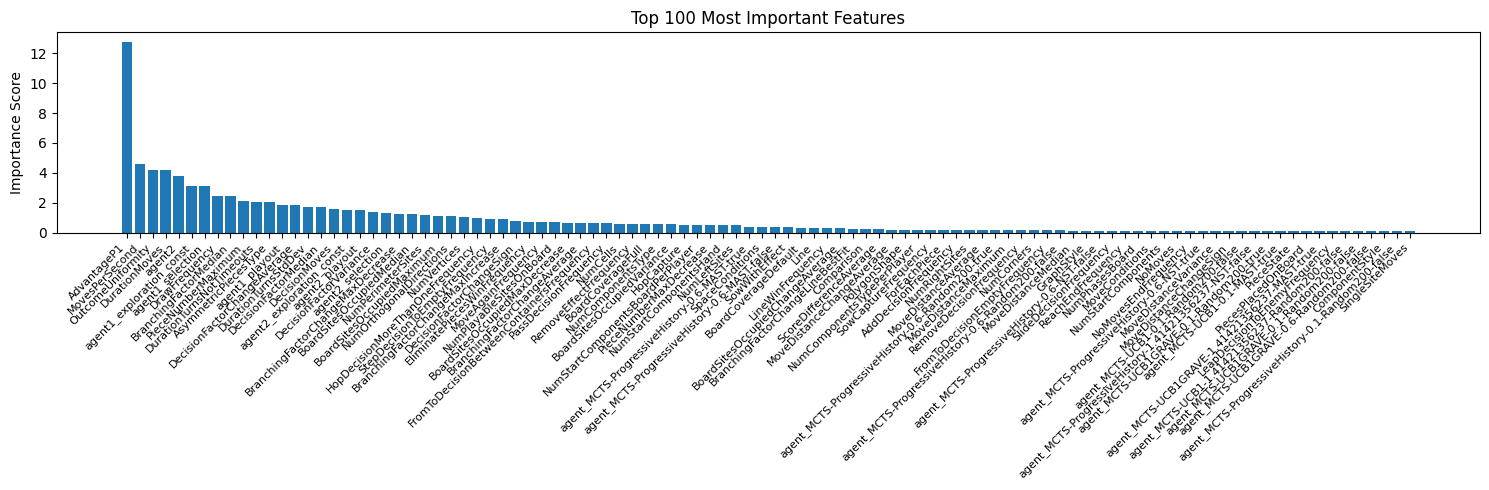

Fold 2 - RMSE: 0.4360404764467269
Fold 3


0:	learn: 0.6039398	test: 0.5980454	best: 0.5980454 (0)	total: 79.1ms	remaining: 3m 57s


50:	learn: 0.3860346	test: 0.4676892	best: 0.4676892 (50)	total: 4.79s	remaining: 4m 37s


100:	learn: 0.3505215	test: 0.4485538	best: 0.4485538 (100)	total: 9.7s	remaining: 4m 38s


150:	learn: 0.3286965	test: 0.4428084	best: 0.4428084 (150)	total: 14.6s	remaining: 4m 34s


200:	learn: 0.3132953	test: 0.4389025	best: 0.4388389 (197)	total: 19.5s	remaining: 4m 31s


250:	learn: 0.3018416	test: 0.4366002	best: 0.4366002 (250)	total: 24.5s	remaining: 4m 27s


300:	learn: 0.2915180	test: 0.4349022	best: 0.4348994 (299)	total: 29.4s	remaining: 4m 23s


350:	learn: 0.2836189	test: 0.4333645	best: 0.4333391 (349)	total: 34.3s	remaining: 4m 19s


400:	learn: 0.2772609	test: 0.4326733	best: 0.4326235 (396)	total: 39.3s	remaining: 4m 14s


450:	learn: 0.2708278	test: 0.4320091	best: 0.4320091 (450)	total: 44.3s	remaining: 4m 10s


500:	learn: 0.2658407	test: 0.4309143	best: 0.4309143 (500)	total: 49.2s	remaining: 4m 5s


550:	learn: 0.2609047	test: 0.4302841	best: 0.4302841 (550)	total: 54.3s	remaining: 4m 1s


600:	learn: 0.2565903	test: 0.4294746	best: 0.4294746 (600)	total: 59.2s	remaining: 3m 56s


650:	learn: 0.2528538	test: 0.4291666	best: 0.4291666 (650)	total: 1m 4s	remaining: 3m 51s


700:	learn: 0.2494789	test: 0.4288747	best: 0.4288587 (699)	total: 1m 9s	remaining: 3m 46s


750:	learn: 0.2460015	test: 0.4286489	best: 0.4286110 (733)	total: 1m 14s	remaining: 3m 42s


800:	learn: 0.2430270	test: 0.4283800	best: 0.4283800 (800)	total: 1m 19s	remaining: 3m 37s


850:	learn: 0.2401064	test: 0.4281637	best: 0.4281637 (850)	total: 1m 24s	remaining: 3m 32s


900:	learn: 0.2371729	test: 0.4278620	best: 0.4278620 (900)	total: 1m 29s	remaining: 3m 28s


950:	learn: 0.2345397	test: 0.4277768	best: 0.4277346 (932)	total: 1m 34s	remaining: 3m 23s


1000:	learn: 0.2320413	test: 0.4275481	best: 0.4275004 (993)	total: 1m 39s	remaining: 3m 18s


1050:	learn: 0.2295841	test: 0.4272964	best: 0.4272863 (1049)	total: 1m 44s	remaining: 3m 14s


1100:	learn: 0.2273284	test: 0.4271365	best: 0.4271277 (1097)	total: 1m 49s	remaining: 3m 9s


1150:	learn: 0.2248299	test: 0.4270539	best: 0.4270224 (1136)	total: 1m 54s	remaining: 3m 4s


1200:	learn: 0.2226437	test: 0.4267166	best: 0.4267166 (1200)	total: 1m 59s	remaining: 2m 59s


1250:	learn: 0.2204030	test: 0.4264901	best: 0.4264901 (1250)	total: 2m 4s	remaining: 2m 54s


1300:	learn: 0.2184877	test: 0.4264118	best: 0.4263894 (1282)	total: 2m 9s	remaining: 2m 49s


1350:	learn: 0.2165930	test: 0.4263863	best: 0.4263620 (1341)	total: 2m 14s	remaining: 2m 44s


1400:	learn: 0.2147491	test: 0.4262833	best: 0.4262806 (1398)	total: 2m 19s	remaining: 2m 39s


1450:	learn: 0.2129381	test: 0.4262165	best: 0.4261326 (1437)	total: 2m 24s	remaining: 2m 34s


1500:	learn: 0.2110870	test: 0.4260912	best: 0.4260771 (1495)	total: 2m 29s	remaining: 2m 29s


1550:	learn: 0.2094696	test: 0.4260722	best: 0.4260702 (1547)	total: 2m 34s	remaining: 2m 24s


1600:	learn: 0.2078013	test: 0.4260590	best: 0.4259986 (1562)	total: 2m 40s	remaining: 2m 19s


1650:	learn: 0.2061951	test: 0.4260068	best: 0.4259821 (1642)	total: 2m 45s	remaining: 2m 14s


1700:	learn: 0.2046297	test: 0.4260059	best: 0.4259754 (1653)	total: 2m 50s	remaining: 2m 9s


1750:	learn: 0.2029944	test: 0.4260756	best: 0.4259620 (1706)	total: 2m 55s	remaining: 2m 4s


1800:	learn: 0.2015455	test: 0.4259928	best: 0.4259620 (1706)	total: 3m	remaining: 1m 59s


1850:	learn: 0.2001856	test: 0.4259522	best: 0.4259455 (1849)	total: 3m 5s	remaining: 1m 55s


1900:	learn: 0.1986865	test: 0.4259056	best: 0.4258862 (1897)	total: 3m 10s	remaining: 1m 50s


1950:	learn: 0.1972201	test: 0.4259101	best: 0.4258862 (1897)	total: 3m 15s	remaining: 1m 45s


2000:	learn: 0.1958497	test: 0.4258958	best: 0.4258739 (1972)	total: 3m 20s	remaining: 1m 40s


2050:	learn: 0.1945764	test: 0.4258455	best: 0.4258222 (2029)	total: 3m 25s	remaining: 1m 35s


2100:	learn: 0.1933177	test: 0.4258237	best: 0.4258222 (2029)	total: 3m 30s	remaining: 1m 30s


2150:	learn: 0.1920233	test: 0.4258015	best: 0.4257647 (2124)	total: 3m 35s	remaining: 1m 25s


2200:	learn: 0.1908131	test: 0.4257632	best: 0.4257516 (2192)	total: 3m 40s	remaining: 1m 20s


2250:	learn: 0.1896387	test: 0.4257288	best: 0.4257039 (2246)	total: 3m 45s	remaining: 1m 15s


2300:	learn: 0.1884691	test: 0.4256910	best: 0.4256910 (2300)	total: 3m 51s	remaining: 1m 10s


2350:	learn: 0.1871142	test: 0.4256587	best: 0.4256587 (2350)	total: 3m 56s	remaining: 1m 5s


2400:	learn: 0.1858296	test: 0.4255983	best: 0.4255833 (2397)	total: 4m 1s	remaining: 1m


2450:	learn: 0.1846816	test: 0.4255069	best: 0.4254902 (2432)	total: 4m 6s	remaining: 55.2s


2500:	learn: 0.1833461	test: 0.4255069	best: 0.4254902 (2432)	total: 4m 11s	remaining: 50.1s


2550:	learn: 0.1821978	test: 0.4254656	best: 0.4254451 (2543)	total: 4m 16s	remaining: 45.1s


2600:	learn: 0.1810555	test: 0.4253706	best: 0.4253706 (2600)	total: 4m 21s	remaining: 40.1s


2650:	learn: 0.1798949	test: 0.4253282	best: 0.4253099 (2638)	total: 4m 26s	remaining: 35.1s


2700:	learn: 0.1788037	test: 0.4252765	best: 0.4252704 (2698)	total: 4m 31s	remaining: 30s


2750:	learn: 0.1777748	test: 0.4251746	best: 0.4251696 (2742)	total: 4m 36s	remaining: 25s


2800:	learn: 0.1767889	test: 0.4250984	best: 0.4250843 (2788)	total: 4m 41s	remaining: 20s


2850:	learn: 0.1757218	test: 0.4251033	best: 0.4250843 (2788)	total: 4m 46s	remaining: 15s


2900:	learn: 0.1746683	test: 0.4250603	best: 0.4250501 (2893)	total: 4m 51s	remaining: 9.96s


2950:	learn: 0.1737119	test: 0.4250686	best: 0.4250501 (2893)	total: 4m 56s	remaining: 4.93s


2999:	learn: 0.1727589	test: 0.4250730	best: 0.4250501 (2893)	total: 5m 1s	remaining: 0us

bestTest = 0.4250500776
bestIteration = 2893

Shrink model to first 2894 iterations.


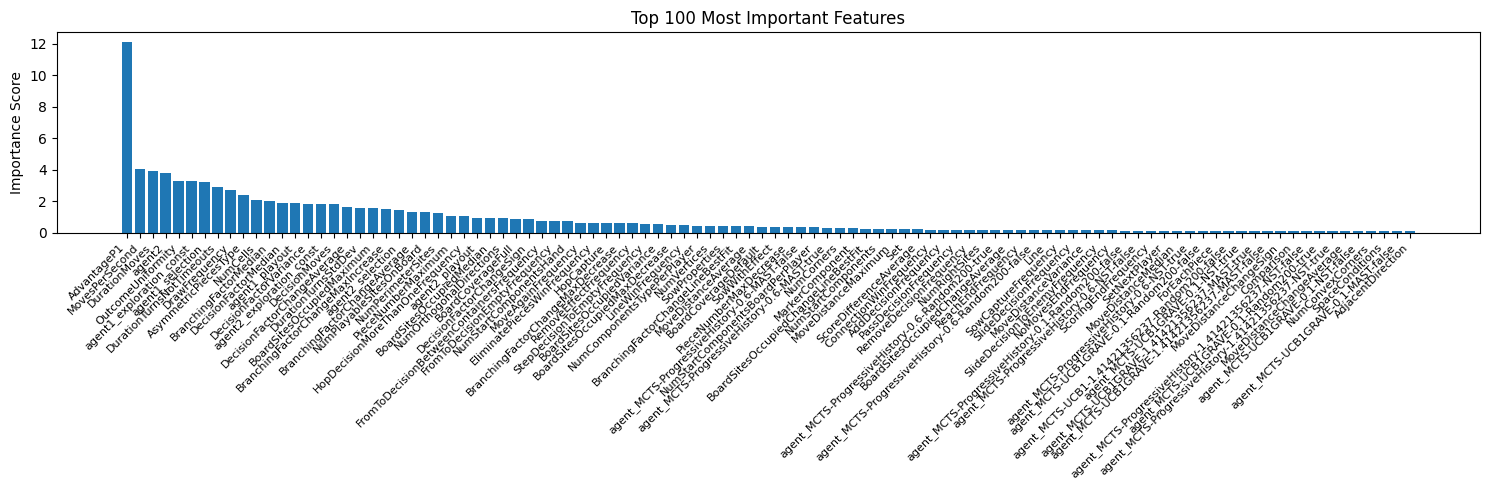

Fold 3 - RMSE: 0.4243317940131267
Fold 4


0:	learn: 0.6037063	test: 0.5901228	best: 0.5901228 (0)	total: 86.2ms	remaining: 4m 18s


50:	learn: 0.3841590	test: 0.4787835	best: 0.4787835 (50)	total: 4.72s	remaining: 4m 32s


100:	learn: 0.3455067	test: 0.4616900	best: 0.4616900 (100)	total: 9.66s	remaining: 4m 37s


150:	learn: 0.3248950	test: 0.4537275	best: 0.4537275 (150)	total: 14.6s	remaining: 4m 35s


200:	learn: 0.3097698	test: 0.4497818	best: 0.4497818 (200)	total: 19.5s	remaining: 4m 31s


250:	learn: 0.2989977	test: 0.4472651	best: 0.4472651 (250)	total: 24.5s	remaining: 4m 28s


300:	learn: 0.2899524	test: 0.4459209	best: 0.4459209 (300)	total: 29.5s	remaining: 4m 24s


350:	learn: 0.2818118	test: 0.4439256	best: 0.4439256 (350)	total: 34.4s	remaining: 4m 19s


400:	learn: 0.2748570	test: 0.4425195	best: 0.4425195 (400)	total: 39.4s	remaining: 4m 15s


450:	learn: 0.2686942	test: 0.4417341	best: 0.4417117 (444)	total: 44.5s	remaining: 4m 11s


500:	learn: 0.2633672	test: 0.4408309	best: 0.4408309 (500)	total: 49.5s	remaining: 4m 6s


550:	learn: 0.2586308	test: 0.4402247	best: 0.4402247 (550)	total: 54.5s	remaining: 4m 2s


600:	learn: 0.2548718	test: 0.4397255	best: 0.4396962 (599)	total: 59.5s	remaining: 3m 57s


650:	learn: 0.2510628	test: 0.4393119	best: 0.4392632 (643)	total: 1m 4s	remaining: 3m 53s


700:	learn: 0.2472854	test: 0.4389772	best: 0.4389301 (695)	total: 1m 9s	remaining: 3m 48s


750:	learn: 0.2436823	test: 0.4385111	best: 0.4385111 (750)	total: 1m 14s	remaining: 3m 43s


800:	learn: 0.2405684	test: 0.4380790	best: 0.4380790 (800)	total: 1m 19s	remaining: 3m 38s


850:	learn: 0.2377396	test: 0.4378493	best: 0.4378355 (846)	total: 1m 24s	remaining: 3m 34s


900:	learn: 0.2350898	test: 0.4376437	best: 0.4376419 (871)	total: 1m 29s	remaining: 3m 29s


950:	learn: 0.2324129	test: 0.4372947	best: 0.4372777 (948)	total: 1m 35s	remaining: 3m 24s


1000:	learn: 0.2298929	test: 0.4369378	best: 0.4369378 (1000)	total: 1m 40s	remaining: 3m 20s


1050:	learn: 0.2273773	test: 0.4368011	best: 0.4367568 (1040)	total: 1m 45s	remaining: 3m 15s


1100:	learn: 0.2250281	test: 0.4365177	best: 0.4365177 (1100)	total: 1m 50s	remaining: 3m 10s


1150:	learn: 0.2229566	test: 0.4363790	best: 0.4363790 (1150)	total: 1m 55s	remaining: 3m 5s


1200:	learn: 0.2207115	test: 0.4363829	best: 0.4363376 (1158)	total: 2m	remaining: 3m


1250:	learn: 0.2186337	test: 0.4362409	best: 0.4362316 (1224)	total: 2m 5s	remaining: 2m 55s


1300:	learn: 0.2167017	test: 0.4362226	best: 0.4361931 (1279)	total: 2m 10s	remaining: 2m 50s


1350:	learn: 0.2149549	test: 0.4361262	best: 0.4361194 (1349)	total: 2m 15s	remaining: 2m 45s


1400:	learn: 0.2132410	test: 0.4360401	best: 0.4360286 (1386)	total: 2m 20s	remaining: 2m 40s


1450:	learn: 0.2114200	test: 0.4359643	best: 0.4359264 (1427)	total: 2m 26s	remaining: 2m 35s


1500:	learn: 0.2097167	test: 0.4358686	best: 0.4358686 (1500)	total: 2m 31s	remaining: 2m 30s


1550:	learn: 0.2080034	test: 0.4357934	best: 0.4357849 (1531)	total: 2m 36s	remaining: 2m 25s


1600:	learn: 0.2065053	test: 0.4357625	best: 0.4357137 (1590)	total: 2m 41s	remaining: 2m 20s


1650:	learn: 0.2048693	test: 0.4357482	best: 0.4357000 (1633)	total: 2m 46s	remaining: 2m 15s


1700:	learn: 0.2034080	test: 0.4358512	best: 0.4357000 (1633)	total: 2m 51s	remaining: 2m 10s


1750:	learn: 0.2019177	test: 0.4357330	best: 0.4357000 (1633)	total: 2m 56s	remaining: 2m 5s


1800:	learn: 0.2004202	test: 0.4355767	best: 0.4355767 (1800)	total: 3m 1s	remaining: 2m


1850:	learn: 0.1990231	test: 0.4354819	best: 0.4354691 (1838)	total: 3m 6s	remaining: 1m 55s


1900:	learn: 0.1975428	test: 0.4354730	best: 0.4354524 (1898)	total: 3m 11s	remaining: 1m 50s


1950:	learn: 0.1962013	test: 0.4354617	best: 0.4354290 (1942)	total: 3m 16s	remaining: 1m 45s


2000:	learn: 0.1947313	test: 0.4354384	best: 0.4354287 (1975)	total: 3m 22s	remaining: 1m 40s


2050:	learn: 0.1934774	test: 0.4353695	best: 0.4353617 (2046)	total: 3m 27s	remaining: 1m 35s


2100:	learn: 0.1922064	test: 0.4353027	best: 0.4352847 (2097)	total: 3m 32s	remaining: 1m 30s


2150:	learn: 0.1910208	test: 0.4352051	best: 0.4352045 (2148)	total: 3m 37s	remaining: 1m 25s


2200:	learn: 0.1898007	test: 0.4351630	best: 0.4351411 (2185)	total: 3m 42s	remaining: 1m 20s


2250:	learn: 0.1886739	test: 0.4351994	best: 0.4351411 (2185)	total: 3m 47s	remaining: 1m 15s


2300:	learn: 0.1874589	test: 0.4351464	best: 0.4351410 (2284)	total: 3m 52s	remaining: 1m 10s


2350:	learn: 0.1863583	test: 0.4351174	best: 0.4350946 (2349)	total: 3m 57s	remaining: 1m 5s


2400:	learn: 0.1850922	test: 0.4350790	best: 0.4350640 (2389)	total: 4m 2s	remaining: 1m


2450:	learn: 0.1837740	test: 0.4350507	best: 0.4350405 (2414)	total: 4m 7s	remaining: 55.5s


2500:	learn: 0.1826011	test: 0.4349740	best: 0.4349731 (2499)	total: 4m 13s	remaining: 50.5s


2550:	learn: 0.1815694	test: 0.4350132	best: 0.4349605 (2537)	total: 4m 18s	remaining: 45.4s


2600:	learn: 0.1805437	test: 0.4349986	best: 0.4349605 (2537)	total: 4m 23s	remaining: 40.4s


2650:	learn: 0.1792897	test: 0.4348805	best: 0.4348805 (2650)	total: 4m 28s	remaining: 35.3s


2700:	learn: 0.1782115	test: 0.4348310	best: 0.4348286 (2697)	total: 4m 33s	remaining: 30.3s


2750:	learn: 0.1771381	test: 0.4347770	best: 0.4347712 (2749)	total: 4m 38s	remaining: 25.2s


2800:	learn: 0.1759291	test: 0.4347140	best: 0.4347140 (2800)	total: 4m 43s	remaining: 20.1s


2850:	learn: 0.1748105	test: 0.4346046	best: 0.4346046 (2850)	total: 4m 48s	remaining: 15.1s


2900:	learn: 0.1738147	test: 0.4345505	best: 0.4345448 (2896)	total: 4m 53s	remaining: 10s


2950:	learn: 0.1728620	test: 0.4345500	best: 0.4345355 (2914)	total: 4m 58s	remaining: 4.96s


2999:	learn: 0.1719705	test: 0.4345257	best: 0.4345098 (2991)	total: 5m 3s	remaining: 0us

bestTest = 0.4345098445
bestIteration = 2991

Shrink model to first 2992 iterations.


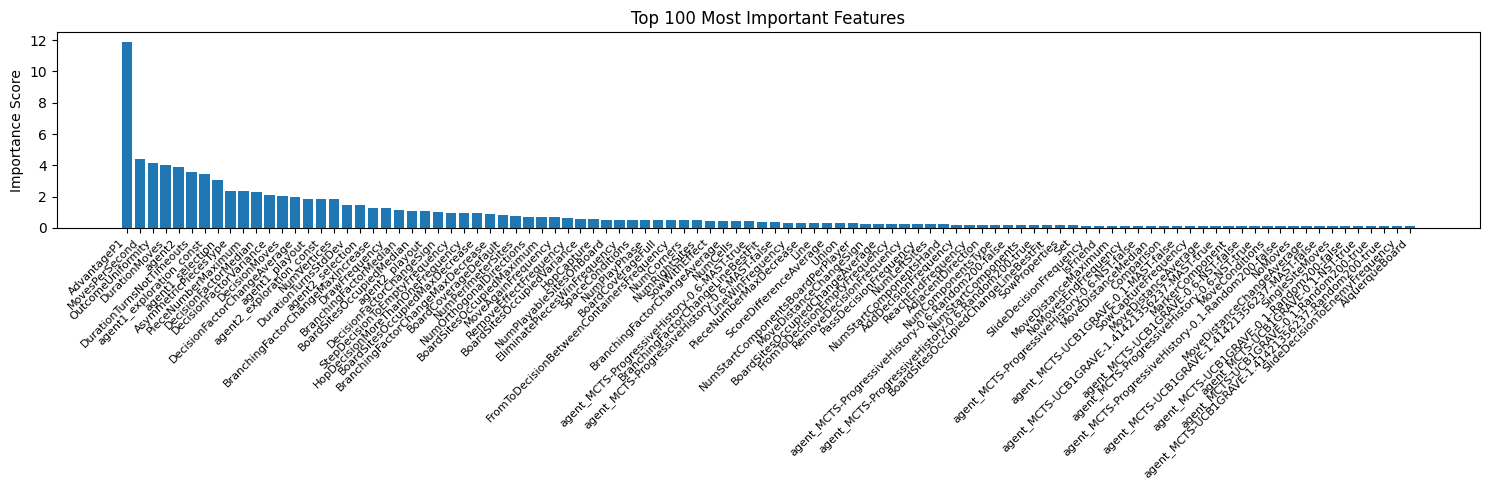

Fold 4 - RMSE: 0.4333316817890145
Fold 5


0:	learn: 0.6157139	test: 0.5450123	best: 0.5450123 (0)	total: 74.5ms	remaining: 3m 43s


50:	learn: 0.3923207	test: 0.4470580	best: 0.4470580 (50)	total: 4.65s	remaining: 4m 29s


100:	learn: 0.3544597	test: 0.4309496	best: 0.4309496 (100)	total: 9.51s	remaining: 4m 32s


150:	learn: 0.3318393	test: 0.4236680	best: 0.4236192 (149)	total: 14.4s	remaining: 4m 31s


200:	learn: 0.3160629	test: 0.4210977	best: 0.4210977 (200)	total: 19.3s	remaining: 4m 28s


250:	learn: 0.3039618	test: 0.4178090	best: 0.4178054 (249)	total: 24.2s	remaining: 4m 25s


300:	learn: 0.2952210	test: 0.4157513	best: 0.4157513 (300)	total: 29.3s	remaining: 4m 22s


350:	learn: 0.2867234	test: 0.4142369	best: 0.4142369 (350)	total: 34.2s	remaining: 4m 18s


400:	learn: 0.2800215	test: 0.4131218	best: 0.4131218 (400)	total: 39.2s	remaining: 4m 14s


450:	learn: 0.2741910	test: 0.4124752	best: 0.4124752 (450)	total: 44.2s	remaining: 4m 9s


500:	learn: 0.2687395	test: 0.4117753	best: 0.4117124 (486)	total: 49.2s	remaining: 4m 5s


550:	learn: 0.2640953	test: 0.4110134	best: 0.4110134 (550)	total: 54.2s	remaining: 4m


600:	learn: 0.2593011	test: 0.4104022	best: 0.4103881 (599)	total: 59.1s	remaining: 3m 55s


650:	learn: 0.2553273	test: 0.4099712	best: 0.4099712 (650)	total: 1m 4s	remaining: 3m 51s


700:	learn: 0.2515216	test: 0.4095631	best: 0.4095522 (697)	total: 1m 9s	remaining: 3m 46s


750:	learn: 0.2480243	test: 0.4092208	best: 0.4092144 (749)	total: 1m 14s	remaining: 3m 41s


800:	learn: 0.2447013	test: 0.4090585	best: 0.4090373 (799)	total: 1m 19s	remaining: 3m 36s


850:	learn: 0.2414178	test: 0.4089788	best: 0.4089677 (848)	total: 1m 24s	remaining: 3m 32s


900:	learn: 0.2386328	test: 0.4088590	best: 0.4088590 (900)	total: 1m 28s	remaining: 3m 27s


950:	learn: 0.2359110	test: 0.4084905	best: 0.4084861 (949)	total: 1m 34s	remaining: 3m 22s


1000:	learn: 0.2333405	test: 0.4083799	best: 0.4083799 (999)	total: 1m 38s	remaining: 3m 17s


1050:	learn: 0.2309053	test: 0.4083599	best: 0.4083278 (1027)	total: 1m 44s	remaining: 3m 13s


1100:	learn: 0.2286373	test: 0.4084181	best: 0.4083278 (1027)	total: 1m 49s	remaining: 3m 8s


1150:	learn: 0.2264214	test: 0.4082136	best: 0.4082117 (1149)	total: 1m 54s	remaining: 3m 3s


1200:	learn: 0.2241788	test: 0.4081215	best: 0.4080976 (1198)	total: 1m 59s	remaining: 2m 58s


1250:	learn: 0.2218713	test: 0.4080927	best: 0.4080674 (1202)	total: 2m 4s	remaining: 2m 53s


1300:	learn: 0.2198399	test: 0.4080290	best: 0.4080135 (1260)	total: 2m 9s	remaining: 2m 48s


1350:	learn: 0.2180455	test: 0.4078027	best: 0.4077960 (1345)	total: 2m 14s	remaining: 2m 43s


1400:	learn: 0.2161552	test: 0.4078204	best: 0.4077614 (1376)	total: 2m 19s	remaining: 2m 38s


1450:	learn: 0.2143696	test: 0.4077830	best: 0.4077614 (1376)	total: 2m 24s	remaining: 2m 33s


1500:	learn: 0.2124650	test: 0.4076489	best: 0.4076430 (1479)	total: 2m 29s	remaining: 2m 29s


1550:	learn: 0.2108920	test: 0.4074477	best: 0.4074477 (1550)	total: 2m 34s	remaining: 2m 24s


1600:	learn: 0.2091920	test: 0.4074260	best: 0.4074243 (1598)	total: 2m 39s	remaining: 2m 19s


1650:	learn: 0.2076547	test: 0.4073323	best: 0.4073074 (1626)	total: 2m 44s	remaining: 2m 14s


1700:	learn: 0.2060403	test: 0.4072451	best: 0.4072361 (1695)	total: 2m 49s	remaining: 2m 9s


1750:	learn: 0.2046873	test: 0.4070610	best: 0.4070610 (1750)	total: 2m 54s	remaining: 2m 4s


1800:	learn: 0.2032198	test: 0.4069820	best: 0.4069612 (1795)	total: 2m 59s	remaining: 1m 59s


1850:	learn: 0.2016980	test: 0.4068014	best: 0.4067965 (1847)	total: 3m 4s	remaining: 1m 54s


1900:	learn: 0.2001886	test: 0.4067744	best: 0.4067605 (1897)	total: 3m 9s	remaining: 1m 49s


1950:	learn: 0.1987604	test: 0.4067275	best: 0.4067150 (1931)	total: 3m 14s	remaining: 1m 44s


2000:	learn: 0.1974436	test: 0.4067019	best: 0.4066716 (1974)	total: 3m 19s	remaining: 1m 39s


2050:	learn: 0.1960708	test: 0.4067017	best: 0.4066716 (1974)	total: 3m 24s	remaining: 1m 34s


2100:	learn: 0.1948416	test: 0.4066736	best: 0.4066563 (2096)	total: 3m 29s	remaining: 1m 29s


2150:	learn: 0.1935002	test: 0.4066108	best: 0.4066108 (2150)	total: 3m 34s	remaining: 1m 24s


2200:	learn: 0.1921501	test: 0.4065652	best: 0.4065568 (2198)	total: 3m 39s	remaining: 1m 19s


2250:	learn: 0.1908054	test: 0.4066318	best: 0.4065405 (2214)	total: 3m 44s	remaining: 1m 14s


2300:	learn: 0.1894836	test: 0.4065681	best: 0.4065405 (2214)	total: 3m 49s	remaining: 1m 9s


2350:	learn: 0.1882458	test: 0.4066188	best: 0.4065405 (2214)	total: 3m 54s	remaining: 1m 4s


2400:	learn: 0.1870147	test: 0.4066509	best: 0.4065405 (2214)	total: 3m 59s	remaining: 59.8s


2450:	learn: 0.1857646	test: 0.4066712	best: 0.4065405 (2214)	total: 4m 4s	remaining: 54.8s


2500:	learn: 0.1844556	test: 0.4066611	best: 0.4065405 (2214)	total: 4m 9s	remaining: 49.8s


2550:	learn: 0.1832254	test: 0.4066265	best: 0.4065405 (2214)	total: 4m 14s	remaining: 44.8s


2600:	learn: 0.1821423	test: 0.4065546	best: 0.4065405 (2214)	total: 4m 19s	remaining: 39.8s


2650:	learn: 0.1809861	test: 0.4066293	best: 0.4065324 (2615)	total: 4m 24s	remaining: 34.8s


2700:	learn: 0.1799933	test: 0.4065887	best: 0.4065324 (2615)	total: 4m 29s	remaining: 29.8s


2750:	learn: 0.1788183	test: 0.4065944	best: 0.4065244 (2715)	total: 4m 34s	remaining: 24.8s


2800:	learn: 0.1776834	test: 0.4065959	best: 0.4065244 (2715)	total: 4m 39s	remaining: 19.9s


2850:	learn: 0.1766536	test: 0.4065708	best: 0.4065244 (2715)	total: 4m 44s	remaining: 14.9s


2900:	learn: 0.1756183	test: 0.4066255	best: 0.4065244 (2715)	total: 4m 49s	remaining: 9.88s


2950:	learn: 0.1746346	test: 0.4066002	best: 0.4065244 (2715)	total: 4m 54s	remaining: 4.89s


2999:	learn: 0.1737416	test: 0.4066683	best: 0.4065244 (2715)	total: 4m 59s	remaining: 0us

bestTest = 0.4065244221
bestIteration = 2715

Shrink model to first 2716 iterations.


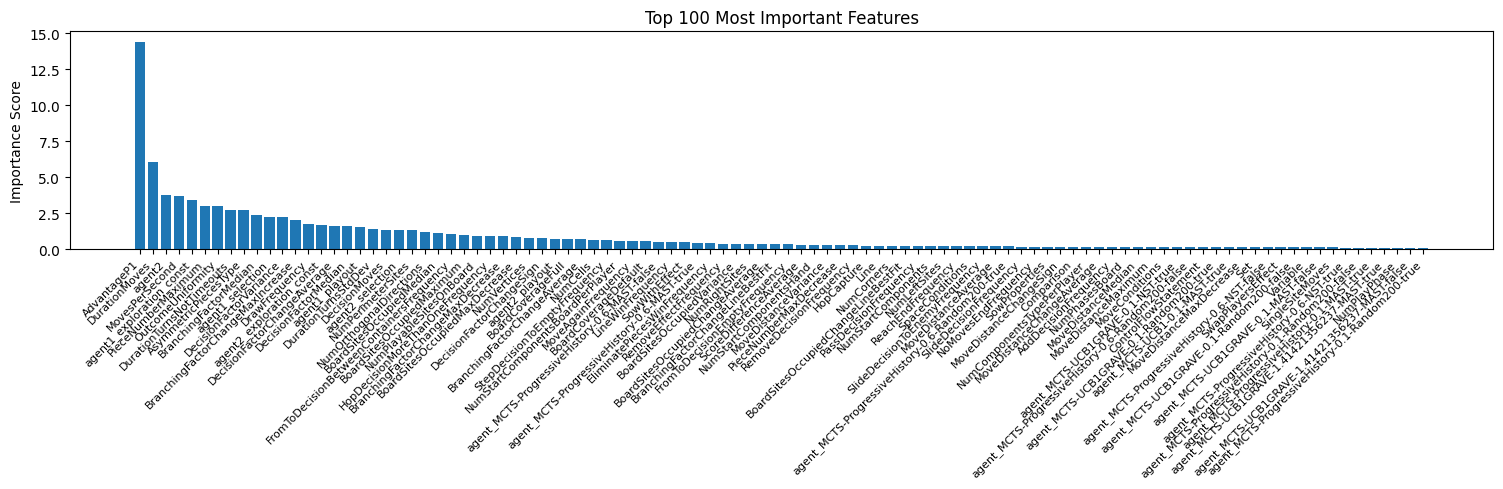

Fold 5 - RMSE: 0.40604298788783494
List of oof scores: [0.4266371835870971, 0.4360404764467269, 0.4243317940131267, 0.4333316817890145, 0.40604298788783494]
Average oof score: 0.42527682474476


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6179675	test: 0.5318759	best: 0.5318759 (0)	total: 81.8ms	remaining: 4m 5s


50:	learn: 0.3916827	test: 0.4544775	best: 0.4544775 (50)	total: 4.66s	remaining: 4m 29s


100:	learn: 0.3513811	test: 0.4395792	best: 0.4395792 (100)	total: 9.61s	remaining: 4m 35s


150:	learn: 0.3283435	test: 0.4338601	best: 0.4337197 (148)	total: 14.4s	remaining: 4m 31s


200:	learn: 0.3129021	test: 0.4301723	best: 0.4301723 (200)	total: 19.4s	remaining: 4m 29s


250:	learn: 0.3016878	test: 0.4276020	best: 0.4276020 (250)	total: 24.3s	remaining: 4m 26s


300:	learn: 0.2919058	test: 0.4261735	best: 0.4259928 (292)	total: 29.2s	remaining: 4m 21s


350:	learn: 0.2841191	test: 0.4247064	best: 0.4246983 (349)	total: 34s	remaining: 4m 16s


400:	learn: 0.2773964	test: 0.4239037	best: 0.4239037 (400)	total: 38.9s	remaining: 4m 12s


450:	learn: 0.2712879	test: 0.4234431	best: 0.4233625 (448)	total: 43.8s	remaining: 4m 7s


500:	learn: 0.2660171	test: 0.4227026	best: 0.4227026 (500)	total: 48.7s	remaining: 4m 3s


550:	learn: 0.2612908	test: 0.4220302	best: 0.4220302 (550)	total: 53.6s	remaining: 3m 58s


600:	learn: 0.2569412	test: 0.4213670	best: 0.4213670 (600)	total: 58.7s	remaining: 3m 54s


650:	learn: 0.2527780	test: 0.4207301	best: 0.4207142 (649)	total: 1m 3s	remaining: 3m 49s


700:	learn: 0.2487207	test: 0.4202119	best: 0.4201984 (699)	total: 1m 8s	remaining: 3m 44s


750:	learn: 0.2449960	test: 0.4200476	best: 0.4200132 (723)	total: 1m 13s	remaining: 3m 39s


800:	learn: 0.2418044	test: 0.4198241	best: 0.4198186 (799)	total: 1m 18s	remaining: 3m 35s


850:	learn: 0.2384709	test: 0.4195900	best: 0.4195530 (843)	total: 1m 23s	remaining: 3m 30s


900:	learn: 0.2353651	test: 0.4195098	best: 0.4194215 (886)	total: 1m 28s	remaining: 3m 25s


950:	learn: 0.2325890	test: 0.4194216	best: 0.4194118 (944)	total: 1m 33s	remaining: 3m 21s


1000:	learn: 0.2300110	test: 0.4192946	best: 0.4192946 (1000)	total: 1m 38s	remaining: 3m 16s


1050:	learn: 0.2276780	test: 0.4190598	best: 0.4190588 (1049)	total: 1m 43s	remaining: 3m 11s


1100:	learn: 0.2253060	test: 0.4187532	best: 0.4187532 (1100)	total: 1m 48s	remaining: 3m 6s


1150:	learn: 0.2231417	test: 0.4186490	best: 0.4186019 (1134)	total: 1m 53s	remaining: 3m 1s


1200:	learn: 0.2209564	test: 0.4184367	best: 0.4184212 (1196)	total: 1m 58s	remaining: 2m 57s


1250:	learn: 0.2189041	test: 0.4181982	best: 0.4181804 (1248)	total: 2m 3s	remaining: 2m 52s


1300:	learn: 0.2168490	test: 0.4181226	best: 0.4181195 (1297)	total: 2m 8s	remaining: 2m 47s


1350:	learn: 0.2148505	test: 0.4180788	best: 0.4180192 (1339)	total: 2m 13s	remaining: 2m 42s


1400:	learn: 0.2128259	test: 0.4180527	best: 0.4180192 (1339)	total: 2m 18s	remaining: 2m 37s


1450:	learn: 0.2108582	test: 0.4178285	best: 0.4178285 (1450)	total: 2m 23s	remaining: 2m 32s


1500:	learn: 0.2088888	test: 0.4178918	best: 0.4178133 (1475)	total: 2m 28s	remaining: 2m 27s


1550:	learn: 0.2072845	test: 0.4177175	best: 0.4177175 (1550)	total: 2m 33s	remaining: 2m 23s


1600:	learn: 0.2056271	test: 0.4176191	best: 0.4176180 (1599)	total: 2m 38s	remaining: 2m 18s


1650:	learn: 0.2039335	test: 0.4175709	best: 0.4175649 (1645)	total: 2m 43s	remaining: 2m 13s


1700:	learn: 0.2023005	test: 0.4175408	best: 0.4174924 (1690)	total: 2m 48s	remaining: 2m 8s


1750:	learn: 0.2006961	test: 0.4174834	best: 0.4174738 (1747)	total: 2m 53s	remaining: 2m 3s


1800:	learn: 0.1992048	test: 0.4174327	best: 0.4174315 (1799)	total: 2m 58s	remaining: 1m 58s


1850:	learn: 0.1976374	test: 0.4174018	best: 0.4173970 (1849)	total: 3m 2s	remaining: 1m 53s


1900:	learn: 0.1961555	test: 0.4173508	best: 0.4173001 (1862)	total: 3m 7s	remaining: 1m 48s


1950:	learn: 0.1947280	test: 0.4173197	best: 0.4172653 (1916)	total: 3m 12s	remaining: 1m 43s


2000:	learn: 0.1932453	test: 0.4173324	best: 0.4172653 (1916)	total: 3m 17s	remaining: 1m 38s


2050:	learn: 0.1918210	test: 0.4172950	best: 0.4172653 (1916)	total: 3m 22s	remaining: 1m 33s


2100:	learn: 0.1904220	test: 0.4172576	best: 0.4172212 (2090)	total: 3m 27s	remaining: 1m 28s


2150:	learn: 0.1890009	test: 0.4171437	best: 0.4171411 (2149)	total: 3m 32s	remaining: 1m 24s


2200:	learn: 0.1877710	test: 0.4171633	best: 0.4171146 (2165)	total: 3m 37s	remaining: 1m 19s


2250:	learn: 0.1864505	test: 0.4171020	best: 0.4170939 (2244)	total: 3m 42s	remaining: 1m 14s


2300:	learn: 0.1852275	test: 0.4171241	best: 0.4170648 (2276)	total: 3m 48s	remaining: 1m 9s


2350:	learn: 0.1839879	test: 0.4170854	best: 0.4170648 (2276)	total: 3m 52s	remaining: 1m 4s


2400:	learn: 0.1827535	test: 0.4170286	best: 0.4170286 (2400)	total: 3m 57s	remaining: 59.4s


2450:	learn: 0.1816193	test: 0.4169879	best: 0.4169877 (2448)	total: 4m 2s	remaining: 54.4s


2500:	learn: 0.1805058	test: 0.4169965	best: 0.4169877 (2448)	total: 4m 7s	remaining: 49.4s


2550:	learn: 0.1793583	test: 0.4169388	best: 0.4169388 (2550)	total: 4m 12s	remaining: 44.5s


2600:	learn: 0.1782944	test: 0.4169663	best: 0.4169388 (2550)	total: 4m 17s	remaining: 39.6s


2650:	learn: 0.1771634	test: 0.4169693	best: 0.4169388 (2625)	total: 4m 22s	remaining: 34.6s


2700:	learn: 0.1760324	test: 0.4169331	best: 0.4169249 (2698)	total: 4m 27s	remaining: 29.7s


2750:	learn: 0.1748566	test: 0.4168937	best: 0.4168851 (2739)	total: 4m 32s	remaining: 24.7s


2800:	learn: 0.1737718	test: 0.4168856	best: 0.4168698 (2791)	total: 4m 37s	remaining: 19.7s


2850:	learn: 0.1726382	test: 0.4167981	best: 0.4167981 (2850)	total: 4m 42s	remaining: 14.8s


2900:	learn: 0.1716317	test: 0.4167766	best: 0.4167485 (2885)	total: 4m 47s	remaining: 9.82s


2950:	learn: 0.1706929	test: 0.4168128	best: 0.4167485 (2885)	total: 4m 52s	remaining: 4.86s


2999:	learn: 0.1697778	test: 0.4167898	best: 0.4167485 (2885)	total: 4m 57s	remaining: 0us

bestTest = 0.4167484786
bestIteration = 2885

Shrink model to first 2886 iterations.


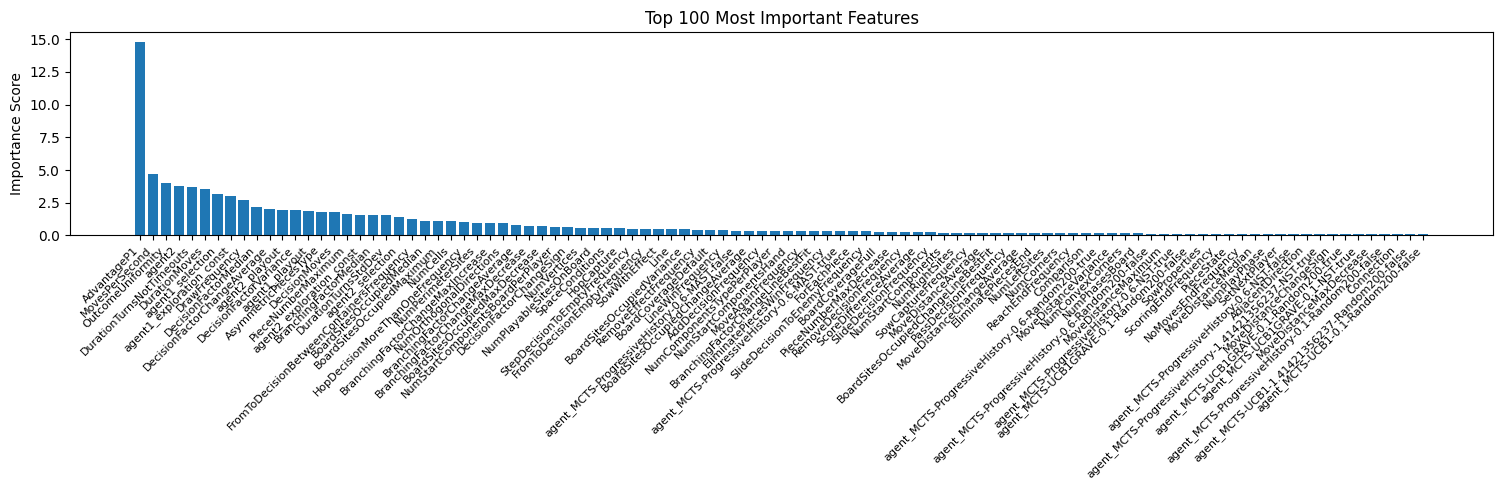

Fold 1 - RMSE: 0.4163514134944492
Fold 2


0:	learn: 0.6145856	test: 0.5380685	best: 0.5380685 (0)	total: 79.4ms	remaining: 3m 58s


50:	learn: 0.3888527	test: 0.4274765	best: 0.4274765 (50)	total: 4.75s	remaining: 4m 34s


100:	learn: 0.3476984	test: 0.4142743	best: 0.4142743 (100)	total: 9.57s	remaining: 4m 34s


150:	learn: 0.3248594	test: 0.4087169	best: 0.4087169 (150)	total: 14.6s	remaining: 4m 35s


200:	learn: 0.3109162	test: 0.4065924	best: 0.4064348 (197)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.2984893	test: 0.4048671	best: 0.4048568 (248)	total: 24.5s	remaining: 4m 28s


300:	learn: 0.2891016	test: 0.4041902	best: 0.4041902 (300)	total: 29.6s	remaining: 4m 25s


350:	learn: 0.2819807	test: 0.4031725	best: 0.4031725 (350)	total: 34.9s	remaining: 4m 23s


400:	learn: 0.2747411	test: 0.4028055	best: 0.4026642 (398)	total: 40.1s	remaining: 4m 20s


450:	learn: 0.2690134	test: 0.4021981	best: 0.4021708 (448)	total: 45.3s	remaining: 4m 15s


500:	learn: 0.2637015	test: 0.4013279	best: 0.4012955 (499)	total: 50.4s	remaining: 4m 11s


550:	learn: 0.2587158	test: 0.4010522	best: 0.4010522 (550)	total: 55.4s	remaining: 4m 6s


600:	learn: 0.2547441	test: 0.4007431	best: 0.4007397 (599)	total: 1m	remaining: 4m 1s


650:	learn: 0.2506433	test: 0.4005846	best: 0.4005714 (649)	total: 1m 5s	remaining: 3m 56s


700:	learn: 0.2466947	test: 0.4001480	best: 0.4001417 (699)	total: 1m 10s	remaining: 3m 51s


750:	learn: 0.2433249	test: 0.4000184	best: 0.4000184 (750)	total: 1m 15s	remaining: 3m 46s


800:	learn: 0.2401482	test: 0.3999127	best: 0.3998596 (781)	total: 1m 20s	remaining: 3m 41s


850:	learn: 0.2370640	test: 0.3999136	best: 0.3998147 (845)	total: 1m 25s	remaining: 3m 36s


900:	learn: 0.2343060	test: 0.3997865	best: 0.3997865 (900)	total: 1m 30s	remaining: 3m 31s


950:	learn: 0.2317348	test: 0.3999295	best: 0.3997536 (910)	total: 1m 35s	remaining: 3m 26s


1000:	learn: 0.2294045	test: 0.3999232	best: 0.3997536 (910)	total: 1m 40s	remaining: 3m 21s


1050:	learn: 0.2270529	test: 0.3999426	best: 0.3997536 (910)	total: 1m 45s	remaining: 3m 16s


1100:	learn: 0.2246188	test: 0.3997431	best: 0.3997168 (1094)	total: 1m 50s	remaining: 3m 11s


1150:	learn: 0.2225639	test: 0.3996733	best: 0.3996733 (1150)	total: 1m 55s	remaining: 3m 6s


1200:	learn: 0.2205521	test: 0.3997881	best: 0.3996568 (1151)	total: 2m	remaining: 3m 1s


1250:	learn: 0.2182848	test: 0.3995872	best: 0.3995653 (1243)	total: 2m 5s	remaining: 2m 56s


1300:	learn: 0.2162656	test: 0.3995880	best: 0.3995370 (1268)	total: 2m 11s	remaining: 2m 51s


1350:	learn: 0.2144088	test: 0.3995474	best: 0.3995370 (1268)	total: 2m 16s	remaining: 2m 46s


1400:	learn: 0.2125827	test: 0.3995657	best: 0.3995219 (1390)	total: 2m 21s	remaining: 2m 41s


1450:	learn: 0.2107181	test: 0.3995756	best: 0.3995219 (1390)	total: 2m 26s	remaining: 2m 36s


1500:	learn: 0.2088992	test: 0.3996959	best: 0.3995219 (1390)	total: 2m 31s	remaining: 2m 31s


1550:	learn: 0.2070674	test: 0.3996845	best: 0.3995219 (1390)	total: 2m 36s	remaining: 2m 25s


1600:	learn: 0.2052576	test: 0.3998164	best: 0.3995219 (1390)	total: 2m 41s	remaining: 2m 20s


1650:	learn: 0.2036118	test: 0.3998770	best: 0.3995219 (1390)	total: 2m 46s	remaining: 2m 15s


1700:	learn: 0.2019519	test: 0.3998828	best: 0.3995219 (1390)	total: 2m 51s	remaining: 2m 10s


1750:	learn: 0.2004081	test: 0.3999458	best: 0.3995219 (1390)	total: 2m 56s	remaining: 2m 5s


1800:	learn: 0.1990173	test: 0.3999614	best: 0.3995219 (1390)	total: 3m 1s	remaining: 2m


1850:	learn: 0.1976664	test: 0.3999078	best: 0.3995219 (1390)	total: 3m 6s	remaining: 1m 55s


1900:	learn: 0.1961972	test: 0.3998832	best: 0.3995219 (1390)	total: 3m 11s	remaining: 1m 50s


1950:	learn: 0.1948591	test: 0.3999981	best: 0.3995219 (1390)	total: 3m 16s	remaining: 1m 45s


2000:	learn: 0.1933784	test: 0.4000134	best: 0.3995219 (1390)	total: 3m 21s	remaining: 1m 40s


2050:	learn: 0.1921137	test: 0.3999839	best: 0.3995219 (1390)	total: 3m 26s	remaining: 1m 35s


2100:	learn: 0.1907537	test: 0.4000451	best: 0.3995219 (1390)	total: 3m 31s	remaining: 1m 30s


2150:	learn: 0.1894354	test: 0.4000591	best: 0.3995219 (1390)	total: 3m 36s	remaining: 1m 25s


2200:	learn: 0.1881449	test: 0.4000387	best: 0.3995219 (1390)	total: 3m 42s	remaining: 1m 20s


2250:	learn: 0.1869964	test: 0.3999835	best: 0.3995219 (1390)	total: 3m 47s	remaining: 1m 15s


2300:	learn: 0.1856580	test: 0.3999953	best: 0.3995219 (1390)	total: 3m 52s	remaining: 1m 10s


2350:	learn: 0.1843581	test: 0.4001062	best: 0.3995219 (1390)	total: 3m 57s	remaining: 1m 5s


2400:	learn: 0.1831627	test: 0.4001379	best: 0.3995219 (1390)	total: 4m 2s	remaining: 1m


2450:	learn: 0.1820099	test: 0.4001618	best: 0.3995219 (1390)	total: 4m 7s	remaining: 55.4s


2500:	learn: 0.1809079	test: 0.4001820	best: 0.3995219 (1390)	total: 4m 12s	remaining: 50.4s


2550:	learn: 0.1798461	test: 0.4001708	best: 0.3995219 (1390)	total: 4m 17s	remaining: 45.3s


2600:	learn: 0.1787414	test: 0.4001617	best: 0.3995219 (1390)	total: 4m 22s	remaining: 40.3s


2650:	learn: 0.1776517	test: 0.4001146	best: 0.3995219 (1390)	total: 4m 27s	remaining: 35.2s


2700:	learn: 0.1766267	test: 0.4002168	best: 0.3995219 (1390)	total: 4m 32s	remaining: 30.2s


2750:	learn: 0.1755727	test: 0.4001881	best: 0.3995219 (1390)	total: 4m 37s	remaining: 25.2s


2800:	learn: 0.1744581	test: 0.4001245	best: 0.3995219 (1390)	total: 4m 43s	remaining: 20.1s


2850:	learn: 0.1733695	test: 0.4001415	best: 0.3995219 (1390)	total: 4m 48s	remaining: 15.1s


2900:	learn: 0.1723378	test: 0.4001031	best: 0.3995219 (1390)	total: 4m 53s	remaining: 10s


2950:	learn: 0.1714489	test: 0.4000732	best: 0.3995219 (1390)	total: 4m 58s	remaining: 4.95s


2999:	learn: 0.1704872	test: 0.4000788	best: 0.3995219 (1390)	total: 5m 3s	remaining: 0us

bestTest = 0.39952191
bestIteration = 1390

Shrink model to first 1391 iterations.


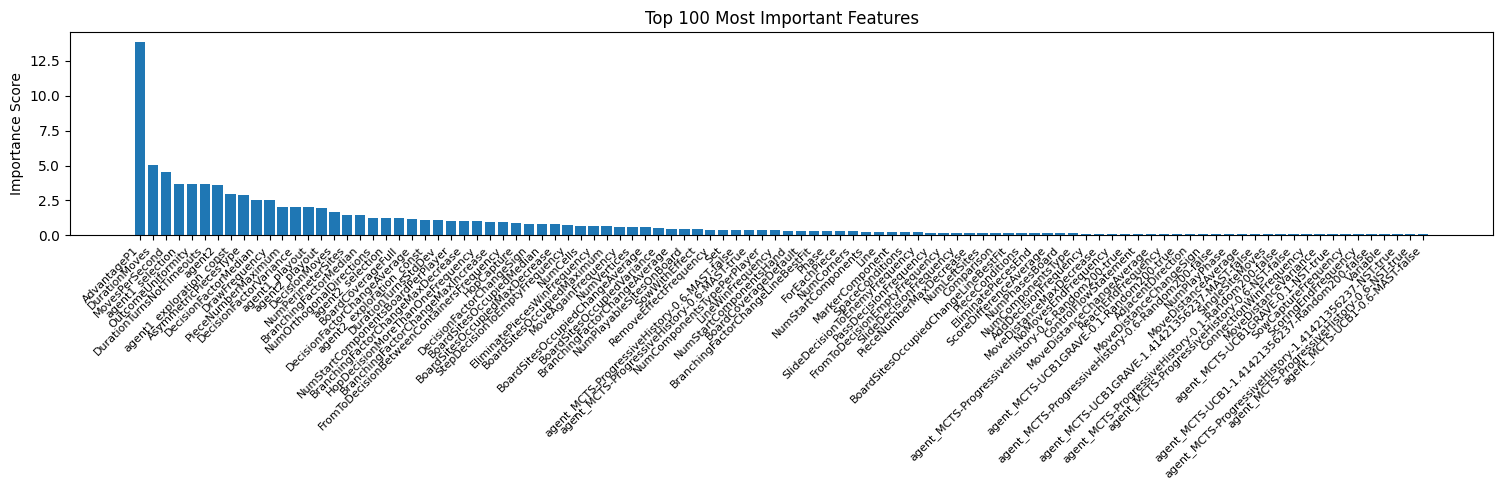

Fold 2 - RMSE: 0.39895681410250267
Fold 3


0:	learn: 0.6018447	test: 0.6084838	best: 0.6084838 (0)	total: 76.8ms	remaining: 3m 50s


50:	learn: 0.3798094	test: 0.4819998	best: 0.4819998 (50)	total: 4.73s	remaining: 4m 33s


100:	learn: 0.3420873	test: 0.4601213	best: 0.4601213 (100)	total: 9.55s	remaining: 4m 34s


150:	learn: 0.3224453	test: 0.4516865	best: 0.4516717 (149)	total: 14.5s	remaining: 4m 33s


200:	learn: 0.3064197	test: 0.4459812	best: 0.4458977 (198)	total: 19.4s	remaining: 4m 30s


250:	learn: 0.2953425	test: 0.4424375	best: 0.4424375 (250)	total: 24.4s	remaining: 4m 27s


300:	learn: 0.2866201	test: 0.4406235	best: 0.4406235 (300)	total: 29.3s	remaining: 4m 23s


350:	learn: 0.2790949	test: 0.4395929	best: 0.4395636 (349)	total: 34.4s	remaining: 4m 19s


400:	learn: 0.2724800	test: 0.4385574	best: 0.4385303 (399)	total: 39.3s	remaining: 4m 14s


450:	learn: 0.2666189	test: 0.4382730	best: 0.4382730 (450)	total: 44.2s	remaining: 4m 10s


500:	learn: 0.2617068	test: 0.4373308	best: 0.4373209 (495)	total: 49.3s	remaining: 4m 6s


550:	learn: 0.2569109	test: 0.4366623	best: 0.4366623 (550)	total: 54.3s	remaining: 4m 1s


600:	learn: 0.2524097	test: 0.4357800	best: 0.4357800 (600)	total: 59.2s	remaining: 3m 56s


650:	learn: 0.2490079	test: 0.4353815	best: 0.4353815 (650)	total: 1m 4s	remaining: 3m 51s


700:	learn: 0.2452995	test: 0.4346075	best: 0.4346067 (698)	total: 1m 9s	remaining: 3m 47s


750:	learn: 0.2415682	test: 0.4341517	best: 0.4341365 (749)	total: 1m 14s	remaining: 3m 42s


800:	learn: 0.2383937	test: 0.4337262	best: 0.4337262 (800)	total: 1m 19s	remaining: 3m 38s


850:	learn: 0.2356025	test: 0.4335562	best: 0.4335131 (826)	total: 1m 24s	remaining: 3m 33s


900:	learn: 0.2327692	test: 0.4330309	best: 0.4330309 (900)	total: 1m 29s	remaining: 3m 28s


950:	learn: 0.2302041	test: 0.4327294	best: 0.4327202 (949)	total: 1m 34s	remaining: 3m 24s


1000:	learn: 0.2277359	test: 0.4325414	best: 0.4325242 (998)	total: 1m 39s	remaining: 3m 19s


1050:	learn: 0.2254254	test: 0.4322494	best: 0.4322494 (1050)	total: 1m 44s	remaining: 3m 14s


1100:	learn: 0.2228829	test: 0.4319227	best: 0.4319103 (1088)	total: 1m 49s	remaining: 3m 9s


1150:	learn: 0.2208335	test: 0.4318164	best: 0.4318140 (1139)	total: 1m 54s	remaining: 3m 4s


1200:	learn: 0.2188708	test: 0.4316180	best: 0.4316092 (1199)	total: 1m 59s	remaining: 2m 59s


1250:	learn: 0.2167881	test: 0.4315284	best: 0.4315061 (1249)	total: 2m 4s	remaining: 2m 54s


1300:	learn: 0.2150790	test: 0.4313110	best: 0.4313110 (1300)	total: 2m 10s	remaining: 2m 49s


1350:	learn: 0.2133335	test: 0.4312572	best: 0.4312396 (1340)	total: 2m 15s	remaining: 2m 44s


1400:	learn: 0.2115285	test: 0.4310426	best: 0.4310224 (1394)	total: 2m 20s	remaining: 2m 39s


1450:	learn: 0.2099076	test: 0.4308413	best: 0.4308413 (1450)	total: 2m 25s	remaining: 2m 35s


1500:	learn: 0.2081721	test: 0.4307020	best: 0.4307020 (1500)	total: 2m 30s	remaining: 2m 30s


1550:	learn: 0.2063780	test: 0.4305668	best: 0.4305668 (1550)	total: 2m 35s	remaining: 2m 25s


1600:	learn: 0.2047461	test: 0.4304913	best: 0.4304599 (1586)	total: 2m 40s	remaining: 2m 20s


1650:	learn: 0.2033363	test: 0.4303799	best: 0.4303784 (1649)	total: 2m 45s	remaining: 2m 15s


1700:	learn: 0.2018034	test: 0.4303782	best: 0.4303508 (1659)	total: 2m 50s	remaining: 2m 10s


1750:	learn: 0.2002732	test: 0.4303840	best: 0.4303466 (1731)	total: 2m 55s	remaining: 2m 5s


1800:	learn: 0.1987111	test: 0.4302829	best: 0.4302636 (1794)	total: 3m	remaining: 2m


1850:	learn: 0.1971931	test: 0.4302616	best: 0.4302296 (1816)	total: 3m 5s	remaining: 1m 55s


1900:	learn: 0.1958736	test: 0.4301944	best: 0.4301944 (1898)	total: 3m 10s	remaining: 1m 50s


1950:	learn: 0.1944499	test: 0.4301494	best: 0.4301187 (1935)	total: 3m 15s	remaining: 1m 45s


2000:	learn: 0.1931089	test: 0.4301262	best: 0.4301164 (1999)	total: 3m 20s	remaining: 1m 40s


2050:	learn: 0.1918075	test: 0.4300001	best: 0.4300001 (2050)	total: 3m 25s	remaining: 1m 35s


2100:	learn: 0.1905036	test: 0.4300385	best: 0.4299865 (2056)	total: 3m 30s	remaining: 1m 30s


2150:	learn: 0.1892296	test: 0.4298981	best: 0.4298885 (2149)	total: 3m 35s	remaining: 1m 25s


2200:	learn: 0.1879705	test: 0.4298617	best: 0.4298441 (2163)	total: 3m 40s	remaining: 1m 20s


2250:	learn: 0.1868565	test: 0.4298424	best: 0.4298424 (2250)	total: 3m 45s	remaining: 1m 15s


2300:	learn: 0.1857429	test: 0.4298375	best: 0.4298246 (2260)	total: 3m 51s	remaining: 1m 10s


2350:	learn: 0.1845822	test: 0.4298057	best: 0.4298057 (2350)	total: 3m 56s	remaining: 1m 5s


2400:	learn: 0.1834933	test: 0.4298230	best: 0.4297627 (2367)	total: 4m 1s	remaining: 1m


2450:	learn: 0.1822173	test: 0.4297419	best: 0.4297389 (2434)	total: 4m 6s	remaining: 55.2s


2500:	learn: 0.1811271	test: 0.4297941	best: 0.4297389 (2434)	total: 4m 11s	remaining: 50.1s


2550:	learn: 0.1800819	test: 0.4297828	best: 0.4297389 (2434)	total: 4m 16s	remaining: 45.1s


2600:	learn: 0.1789709	test: 0.4297558	best: 0.4297389 (2434)	total: 4m 21s	remaining: 40.1s


2650:	learn: 0.1779012	test: 0.4296741	best: 0.4296741 (2650)	total: 4m 26s	remaining: 35.1s


2700:	learn: 0.1768146	test: 0.4296399	best: 0.4296399 (2700)	total: 4m 31s	remaining: 30s


2750:	learn: 0.1756580	test: 0.4296542	best: 0.4296338 (2702)	total: 4m 36s	remaining: 25s


2800:	learn: 0.1745825	test: 0.4296289	best: 0.4296061 (2772)	total: 4m 41s	remaining: 20s


2850:	learn: 0.1735971	test: 0.4296474	best: 0.4296061 (2772)	total: 4m 46s	remaining: 15s


2900:	learn: 0.1726497	test: 0.4296598	best: 0.4296061 (2772)	total: 4m 51s	remaining: 9.96s


2950:	learn: 0.1716869	test: 0.4296870	best: 0.4296061 (2772)	total: 4m 56s	remaining: 4.93s


2999:	learn: 0.1707059	test: 0.4296839	best: 0.4296061 (2772)	total: 5m 1s	remaining: 0us

bestTest = 0.4296060775
bestIteration = 2772

Shrink model to first 2773 iterations.


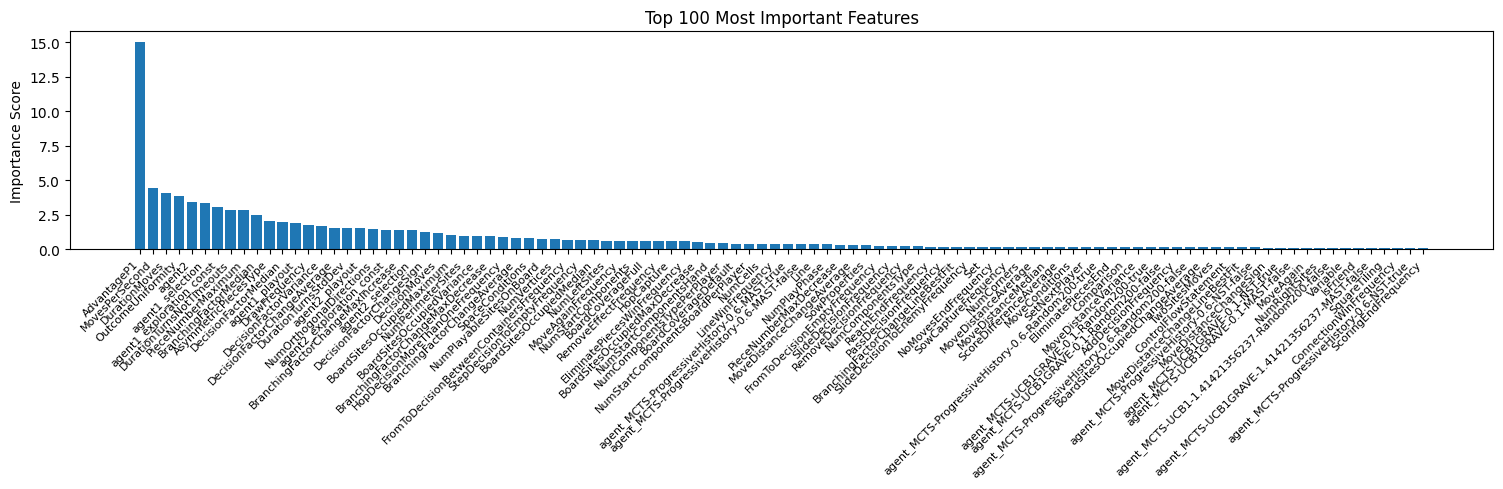

Fold 3 - RMSE: 0.42887465341253217
Fold 4


0:	learn: 0.6037017	test: 0.5973672	best: 0.5973672 (0)	total: 84.7ms	remaining: 4m 13s


50:	learn: 0.3876236	test: 0.4787807	best: 0.4787807 (50)	total: 4.73s	remaining: 4m 33s


100:	learn: 0.3491785	test: 0.4632446	best: 0.4632446 (100)	total: 9.67s	remaining: 4m 37s


150:	learn: 0.3279704	test: 0.4560181	best: 0.4560135 (149)	total: 14.7s	remaining: 4m 36s


200:	learn: 0.3126253	test: 0.4531500	best: 0.4531500 (200)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.3012064	test: 0.4508768	best: 0.4508505 (246)	total: 24.6s	remaining: 4m 29s


300:	learn: 0.2924414	test: 0.4489453	best: 0.4489453 (300)	total: 29.6s	remaining: 4m 25s


350:	learn: 0.2853862	test: 0.4476704	best: 0.4476550 (347)	total: 34.7s	remaining: 4m 22s


400:	learn: 0.2786983	test: 0.4468051	best: 0.4467974 (399)	total: 39.7s	remaining: 4m 17s


450:	learn: 0.2726298	test: 0.4454851	best: 0.4454851 (450)	total: 44.7s	remaining: 4m 12s


500:	learn: 0.2674619	test: 0.4451182	best: 0.4451182 (500)	total: 49.6s	remaining: 4m 7s


550:	learn: 0.2625699	test: 0.4443689	best: 0.4443689 (550)	total: 54.6s	remaining: 4m 2s


600:	learn: 0.2582538	test: 0.4438556	best: 0.4437983 (597)	total: 59.7s	remaining: 3m 58s


650:	learn: 0.2543717	test: 0.4435094	best: 0.4435094 (650)	total: 1m 4s	remaining: 3m 53s


700:	learn: 0.2510728	test: 0.4431402	best: 0.4431263 (691)	total: 1m 9s	remaining: 3m 48s


750:	learn: 0.2478952	test: 0.4429949	best: 0.4429531 (746)	total: 1m 14s	remaining: 3m 43s


800:	learn: 0.2443916	test: 0.4424636	best: 0.4424563 (799)	total: 1m 19s	remaining: 3m 39s


850:	learn: 0.2413426	test: 0.4421997	best: 0.4421977 (849)	total: 1m 24s	remaining: 3m 34s


900:	learn: 0.2386025	test: 0.4420858	best: 0.4420450 (884)	total: 1m 29s	remaining: 3m 29s


950:	learn: 0.2358954	test: 0.4418293	best: 0.4417919 (945)	total: 1m 34s	remaining: 3m 24s


1000:	learn: 0.2333935	test: 0.4416578	best: 0.4416578 (1000)	total: 1m 40s	remaining: 3m 19s


1050:	learn: 0.2312308	test: 0.4414308	best: 0.4414300 (1049)	total: 1m 45s	remaining: 3m 15s


1100:	learn: 0.2288028	test: 0.4414153	best: 0.4413043 (1080)	total: 1m 50s	remaining: 3m 10s


1150:	learn: 0.2265890	test: 0.4411730	best: 0.4411509 (1148)	total: 1m 55s	remaining: 3m 5s


1200:	learn: 0.2245417	test: 0.4412116	best: 0.4411509 (1148)	total: 2m	remaining: 3m


1250:	learn: 0.2224372	test: 0.4411190	best: 0.4411100 (1240)	total: 2m 5s	remaining: 2m 55s


1300:	learn: 0.2204849	test: 0.4409698	best: 0.4409698 (1300)	total: 2m 10s	remaining: 2m 50s


1350:	learn: 0.2185095	test: 0.4409488	best: 0.4409090 (1328)	total: 2m 15s	remaining: 2m 45s


1400:	learn: 0.2164361	test: 0.4408637	best: 0.4408637 (1399)	total: 2m 20s	remaining: 2m 40s


1450:	learn: 0.2147497	test: 0.4407375	best: 0.4407324 (1447)	total: 2m 25s	remaining: 2m 35s


1500:	learn: 0.2129329	test: 0.4406116	best: 0.4405960 (1495)	total: 2m 31s	remaining: 2m 30s


1550:	learn: 0.2111532	test: 0.4405119	best: 0.4404897 (1539)	total: 2m 36s	remaining: 2m 25s


1600:	learn: 0.2094608	test: 0.4403249	best: 0.4403249 (1600)	total: 2m 41s	remaining: 2m 20s


1650:	learn: 0.2076105	test: 0.4403726	best: 0.4402972 (1613)	total: 2m 46s	remaining: 2m 15s


1700:	learn: 0.2059737	test: 0.4403821	best: 0.4402972 (1613)	total: 2m 51s	remaining: 2m 10s


1750:	learn: 0.2044245	test: 0.4402767	best: 0.4402767 (1750)	total: 2m 56s	remaining: 2m 5s


1800:	learn: 0.2029473	test: 0.4402150	best: 0.4402080 (1798)	total: 3m 1s	remaining: 2m


1850:	learn: 0.2014237	test: 0.4401595	best: 0.4401595 (1850)	total: 3m 6s	remaining: 1m 55s


1900:	learn: 0.1998985	test: 0.4400909	best: 0.4400909 (1900)	total: 3m 11s	remaining: 1m 50s


1950:	learn: 0.1985375	test: 0.4400575	best: 0.4400484 (1941)	total: 3m 17s	remaining: 1m 45s


2000:	learn: 0.1971634	test: 0.4399563	best: 0.4399372 (1993)	total: 3m 22s	remaining: 1m 40s


2050:	learn: 0.1956933	test: 0.4399297	best: 0.4398646 (2022)	total: 3m 27s	remaining: 1m 35s


2100:	learn: 0.1944409	test: 0.4399020	best: 0.4398646 (2022)	total: 3m 32s	remaining: 1m 30s


2150:	learn: 0.1932863	test: 0.4398820	best: 0.4398646 (2022)	total: 3m 37s	remaining: 1m 25s


2200:	learn: 0.1920694	test: 0.4398197	best: 0.4398197 (2200)	total: 3m 42s	remaining: 1m 20s


2250:	learn: 0.1908134	test: 0.4399332	best: 0.4398169 (2206)	total: 3m 47s	remaining: 1m 15s


2300:	learn: 0.1897173	test: 0.4399104	best: 0.4398169 (2206)	total: 3m 53s	remaining: 1m 10s


2350:	learn: 0.1885899	test: 0.4399140	best: 0.4398169 (2206)	total: 3m 58s	remaining: 1m 5s


2400:	learn: 0.1874730	test: 0.4398999	best: 0.4398169 (2206)	total: 4m 3s	remaining: 1m


2450:	learn: 0.1863356	test: 0.4399642	best: 0.4398169 (2206)	total: 4m 8s	remaining: 55.7s


2500:	learn: 0.1852220	test: 0.4398830	best: 0.4398169 (2206)	total: 4m 13s	remaining: 50.6s


2550:	learn: 0.1840036	test: 0.4397906	best: 0.4397836 (2547)	total: 4m 18s	remaining: 45.6s


2600:	learn: 0.1828384	test: 0.4397741	best: 0.4397486 (2569)	total: 4m 23s	remaining: 40.5s


2650:	learn: 0.1817343	test: 0.4397782	best: 0.4397486 (2569)	total: 4m 28s	remaining: 35.4s


2700:	learn: 0.1806875	test: 0.4397772	best: 0.4397486 (2569)	total: 4m 34s	remaining: 30.3s


2750:	learn: 0.1796328	test: 0.4397511	best: 0.4397094 (2739)	total: 4m 39s	remaining: 25.3s


2800:	learn: 0.1786452	test: 0.4397483	best: 0.4396990 (2785)	total: 4m 44s	remaining: 20.2s


2850:	learn: 0.1774656	test: 0.4397478	best: 0.4396990 (2785)	total: 4m 49s	remaining: 15.1s


2900:	learn: 0.1765139	test: 0.4396856	best: 0.4396676 (2890)	total: 4m 54s	remaining: 10.1s


2950:	learn: 0.1754606	test: 0.4397498	best: 0.4396676 (2890)	total: 4m 59s	remaining: 4.98s


2999:	learn: 0.1745038	test: 0.4396991	best: 0.4396676 (2890)	total: 5m 4s	remaining: 0us

bestTest = 0.4396675906
bestIteration = 2890

Shrink model to first 2891 iterations.


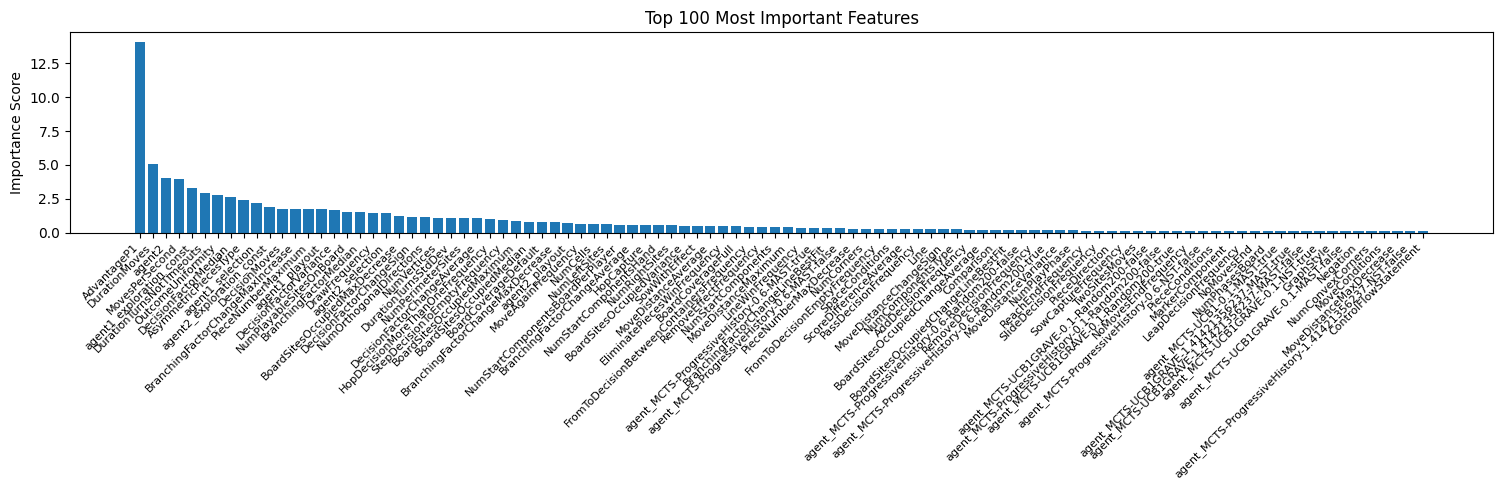

Fold 4 - RMSE: 0.4390144915938929
Fold 5


0:	learn: 0.6047693	test: 0.5893000	best: 0.5893000 (0)	total: 67.7ms	remaining: 3m 23s


50:	learn: 0.3821980	test: 0.4743993	best: 0.4743993 (50)	total: 4.82s	remaining: 4m 38s


100:	learn: 0.3470318	test: 0.4559881	best: 0.4559881 (100)	total: 9.79s	remaining: 4m 41s


150:	learn: 0.3259302	test: 0.4482252	best: 0.4482252 (150)	total: 14.7s	remaining: 4m 37s


200:	learn: 0.3117291	test: 0.4441036	best: 0.4441036 (200)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.2999308	test: 0.4414320	best: 0.4414320 (250)	total: 24.7s	remaining: 4m 29s


300:	learn: 0.2913853	test: 0.4391869	best: 0.4391506 (298)	total: 29.8s	remaining: 4m 27s


350:	learn: 0.2839984	test: 0.4374126	best: 0.4374126 (350)	total: 34.9s	remaining: 4m 23s


400:	learn: 0.2777443	test: 0.4358044	best: 0.4358044 (399)	total: 40s	remaining: 4m 19s


450:	learn: 0.2722444	test: 0.4347183	best: 0.4347153 (449)	total: 45s	remaining: 4m 14s


500:	learn: 0.2668095	test: 0.4340361	best: 0.4339244 (499)	total: 50.1s	remaining: 4m 9s


550:	learn: 0.2618430	test: 0.4332963	best: 0.4332617 (545)	total: 55.2s	remaining: 4m 5s


600:	learn: 0.2576171	test: 0.4323067	best: 0.4322481 (590)	total: 1m	remaining: 4m


650:	learn: 0.2533704	test: 0.4317398	best: 0.4317398 (650)	total: 1m 5s	remaining: 3m 55s


700:	learn: 0.2498049	test: 0.4311581	best: 0.4311581 (700)	total: 1m 10s	remaining: 3m 50s


750:	learn: 0.2465139	test: 0.4308582	best: 0.4308577 (749)	total: 1m 15s	remaining: 3m 46s


800:	learn: 0.2431570	test: 0.4304754	best: 0.4304632 (795)	total: 1m 20s	remaining: 3m 40s


850:	learn: 0.2401289	test: 0.4300237	best: 0.4300237 (850)	total: 1m 25s	remaining: 3m 36s


900:	learn: 0.2375297	test: 0.4296325	best: 0.4296325 (900)	total: 1m 30s	remaining: 3m 31s


950:	learn: 0.2348295	test: 0.4293627	best: 0.4293617 (947)	total: 1m 35s	remaining: 3m 26s


1000:	learn: 0.2323605	test: 0.4291980	best: 0.4291980 (1000)	total: 1m 40s	remaining: 3m 21s


1050:	learn: 0.2296574	test: 0.4289624	best: 0.4289624 (1050)	total: 1m 45s	remaining: 3m 16s


1100:	learn: 0.2274953	test: 0.4287187	best: 0.4286691 (1088)	total: 1m 51s	remaining: 3m 11s


1150:	learn: 0.2253477	test: 0.4283048	best: 0.4283048 (1150)	total: 1m 56s	remaining: 3m 6s


1200:	learn: 0.2232295	test: 0.4280734	best: 0.4280734 (1200)	total: 2m 1s	remaining: 3m 1s


1250:	learn: 0.2210585	test: 0.4279693	best: 0.4279415 (1226)	total: 2m 6s	remaining: 2m 56s


1300:	learn: 0.2189224	test: 0.4276935	best: 0.4276929 (1299)	total: 2m 11s	remaining: 2m 51s


1350:	learn: 0.2169315	test: 0.4276472	best: 0.4276220 (1343)	total: 2m 16s	remaining: 2m 46s


1400:	learn: 0.2149670	test: 0.4276180	best: 0.4275586 (1386)	total: 2m 21s	remaining: 2m 41s


1450:	learn: 0.2131749	test: 0.4274872	best: 0.4274872 (1450)	total: 2m 26s	remaining: 2m 36s


1500:	learn: 0.2113989	test: 0.4274095	best: 0.4274095 (1500)	total: 2m 31s	remaining: 2m 31s


1550:	learn: 0.2097219	test: 0.4272782	best: 0.4272657 (1520)	total: 2m 36s	remaining: 2m 26s


1600:	learn: 0.2081371	test: 0.4272111	best: 0.4272111 (1600)	total: 2m 42s	remaining: 2m 21s


1650:	learn: 0.2063985	test: 0.4269866	best: 0.4269866 (1650)	total: 2m 47s	remaining: 2m 16s


1700:	learn: 0.2049069	test: 0.4269062	best: 0.4269030 (1681)	total: 2m 52s	remaining: 2m 11s


1750:	learn: 0.2034683	test: 0.4268132	best: 0.4268000 (1737)	total: 2m 57s	remaining: 2m 6s


1800:	learn: 0.2020050	test: 0.4266917	best: 0.4266836 (1798)	total: 3m 2s	remaining: 2m 1s


1850:	learn: 0.2004597	test: 0.4265346	best: 0.4265346 (1850)	total: 3m 7s	remaining: 1m 56s


1900:	learn: 0.1989668	test: 0.4266112	best: 0.4265240 (1860)	total: 3m 12s	remaining: 1m 51s


1950:	learn: 0.1977032	test: 0.4264998	best: 0.4264723 (1941)	total: 3m 17s	remaining: 1m 46s


2000:	learn: 0.1963585	test: 0.4264097	best: 0.4263729 (1996)	total: 3m 22s	remaining: 1m 41s


2050:	learn: 0.1951351	test: 0.4263189	best: 0.4263184 (2049)	total: 3m 28s	remaining: 1m 36s


2100:	learn: 0.1937390	test: 0.4262179	best: 0.4261889 (2093)	total: 3m 33s	remaining: 1m 31s


2150:	learn: 0.1923918	test: 0.4260921	best: 0.4260856 (2149)	total: 3m 38s	remaining: 1m 26s


2200:	learn: 0.1910924	test: 0.4260577	best: 0.4260412 (2188)	total: 3m 43s	remaining: 1m 21s


2250:	learn: 0.1897965	test: 0.4259526	best: 0.4259526 (2250)	total: 3m 48s	remaining: 1m 16s


2300:	learn: 0.1886172	test: 0.4259536	best: 0.4259376 (2255)	total: 3m 53s	remaining: 1m 11s


2350:	learn: 0.1873543	test: 0.4258979	best: 0.4258798 (2330)	total: 3m 58s	remaining: 1m 5s


2400:	learn: 0.1862690	test: 0.4258412	best: 0.4258396 (2370)	total: 4m 4s	remaining: 1m


2450:	learn: 0.1851582	test: 0.4258163	best: 0.4257955 (2427)	total: 4m 9s	remaining: 55.8s


2500:	learn: 0.1839720	test: 0.4258238	best: 0.4257888 (2480)	total: 4m 14s	remaining: 50.7s


2550:	learn: 0.1828828	test: 0.4258064	best: 0.4257888 (2480)	total: 4m 19s	remaining: 45.7s


2600:	learn: 0.1817395	test: 0.4258075	best: 0.4257831 (2560)	total: 4m 24s	remaining: 40.6s


2650:	learn: 0.1804862	test: 0.4258240	best: 0.4257831 (2560)	total: 4m 29s	remaining: 35.5s


2700:	learn: 0.1795480	test: 0.4257895	best: 0.4257831 (2560)	total: 4m 34s	remaining: 30.4s


2750:	learn: 0.1784354	test: 0.4258072	best: 0.4257603 (2731)	total: 4m 39s	remaining: 25.3s


2800:	learn: 0.1774158	test: 0.4258269	best: 0.4257603 (2731)	total: 4m 45s	remaining: 20.3s


2850:	learn: 0.1763991	test: 0.4258132	best: 0.4257603 (2731)	total: 4m 50s	remaining: 15.2s


2900:	learn: 0.1753770	test: 0.4257746	best: 0.4257422 (2894)	total: 4m 55s	remaining: 10.1s


2950:	learn: 0.1744396	test: 0.4257806	best: 0.4257422 (2894)	total: 5m	remaining: 4.99s


2999:	learn: 0.1734443	test: 0.4257671	best: 0.4257422 (2894)	total: 5m 5s	remaining: 0us

bestTest = 0.4257422123
bestIteration = 2894

Shrink model to first 2895 iterations.


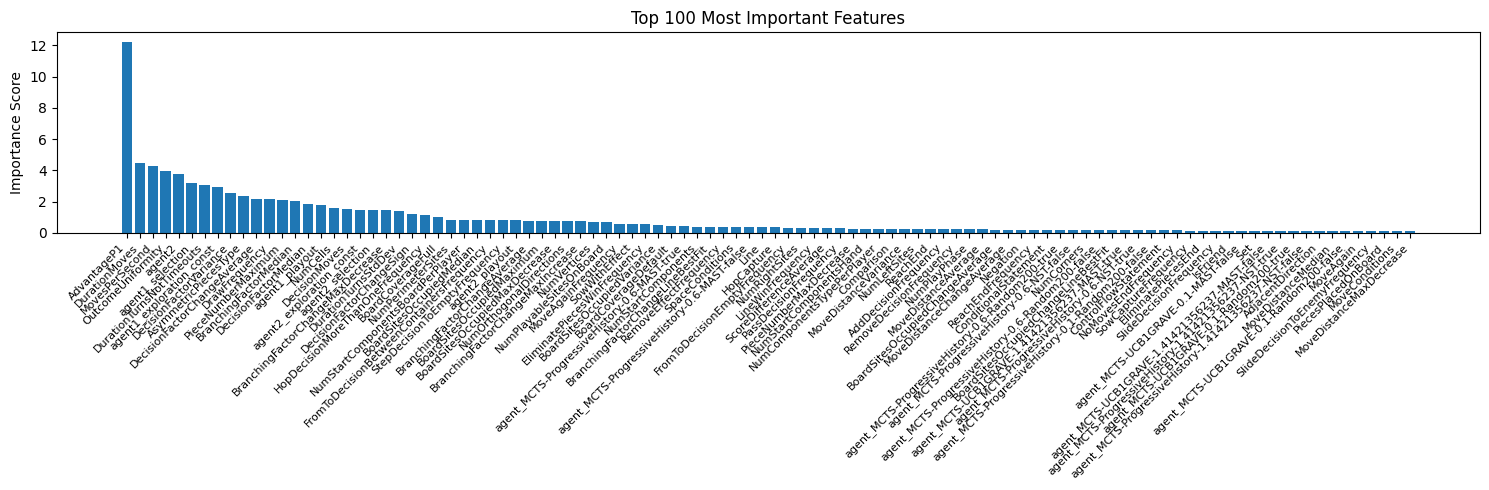

Fold 5 - RMSE: 0.42494737805328
List of oof scores: [0.4163514134944492, 0.39895681410250267, 0.42887465341253217, 0.4390144915938929, 0.42494737805328]
Average oof score: 0.4216289501313314


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6106227	test: 0.5710789	best: 0.5710789 (0)	total: 75.7ms	remaining: 3m 47s


50:	learn: 0.3835721	test: 0.4644225	best: 0.4644225 (50)	total: 4.74s	remaining: 4m 34s


100:	learn: 0.3472490	test: 0.4492026	best: 0.4491575 (99)	total: 9.71s	remaining: 4m 38s


150:	learn: 0.3239413	test: 0.4426943	best: 0.4425442 (149)	total: 14.7s	remaining: 4m 37s


200:	learn: 0.3089505	test: 0.4396532	best: 0.4396532 (200)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.2985434	test: 0.4369880	best: 0.4369880 (250)	total: 24.6s	remaining: 4m 29s


300:	learn: 0.2898853	test: 0.4360764	best: 0.4360764 (300)	total: 29.6s	remaining: 4m 25s


350:	learn: 0.2826037	test: 0.4347123	best: 0.4347123 (350)	total: 34.6s	remaining: 4m 21s


400:	learn: 0.2758517	test: 0.4337753	best: 0.4337548 (397)	total: 39.5s	remaining: 4m 16s


450:	learn: 0.2700158	test: 0.4331568	best: 0.4331078 (445)	total: 44.4s	remaining: 4m 11s


500:	learn: 0.2650334	test: 0.4324223	best: 0.4324223 (500)	total: 49.6s	remaining: 4m 7s


550:	learn: 0.2604129	test: 0.4320754	best: 0.4320754 (550)	total: 54.7s	remaining: 4m 3s


600:	learn: 0.2562776	test: 0.4321393	best: 0.4320002 (553)	total: 59.7s	remaining: 3m 58s


650:	learn: 0.2527004	test: 0.4320487	best: 0.4318208 (626)	total: 1m 4s	remaining: 3m 54s


700:	learn: 0.2491575	test: 0.4316710	best: 0.4316710 (700)	total: 1m 9s	remaining: 3m 49s


750:	learn: 0.2460030	test: 0.4316852	best: 0.4316634 (717)	total: 1m 15s	remaining: 3m 44s


800:	learn: 0.2429257	test: 0.4314116	best: 0.4313935 (791)	total: 1m 20s	remaining: 3m 39s


850:	learn: 0.2398723	test: 0.4313670	best: 0.4312345 (826)	total: 1m 25s	remaining: 3m 35s


900:	learn: 0.2371439	test: 0.4312366	best: 0.4312345 (826)	total: 1m 30s	remaining: 3m 30s


950:	learn: 0.2346162	test: 0.4311287	best: 0.4310621 (944)	total: 1m 35s	remaining: 3m 25s


1000:	learn: 0.2320246	test: 0.4307824	best: 0.4307701 (997)	total: 1m 40s	remaining: 3m 20s


1050:	learn: 0.2296939	test: 0.4307045	best: 0.4307045 (1050)	total: 1m 45s	remaining: 3m 15s


1100:	learn: 0.2273849	test: 0.4305586	best: 0.4305561 (1099)	total: 1m 50s	remaining: 3m 10s


1150:	learn: 0.2253788	test: 0.4303834	best: 0.4303672 (1146)	total: 1m 55s	remaining: 3m 5s


1200:	learn: 0.2234602	test: 0.4303373	best: 0.4302901 (1169)	total: 2m	remaining: 3m


1250:	learn: 0.2213452	test: 0.4301522	best: 0.4301522 (1250)	total: 2m 5s	remaining: 2m 55s


1300:	learn: 0.2193638	test: 0.4298832	best: 0.4298832 (1300)	total: 2m 10s	remaining: 2m 50s


1350:	learn: 0.2174663	test: 0.4298368	best: 0.4297424 (1341)	total: 2m 15s	remaining: 2m 45s


1400:	learn: 0.2157178	test: 0.4297655	best: 0.4297424 (1341)	total: 2m 21s	remaining: 2m 40s


1450:	learn: 0.2138916	test: 0.4296429	best: 0.4296380 (1442)	total: 2m 26s	remaining: 2m 36s


1500:	learn: 0.2122147	test: 0.4296475	best: 0.4296380 (1442)	total: 2m 31s	remaining: 2m 31s


1550:	learn: 0.2103621	test: 0.4295852	best: 0.4295594 (1541)	total: 2m 36s	remaining: 2m 25s


1600:	learn: 0.2086173	test: 0.4295568	best: 0.4295440 (1588)	total: 2m 41s	remaining: 2m 20s


1650:	learn: 0.2069793	test: 0.4295291	best: 0.4295058 (1610)	total: 2m 46s	remaining: 2m 15s


1700:	learn: 0.2054865	test: 0.4294274	best: 0.4294137 (1687)	total: 2m 51s	remaining: 2m 10s


1750:	learn: 0.2040748	test: 0.4293651	best: 0.4293624 (1748)	total: 2m 56s	remaining: 2m 5s


1800:	learn: 0.2025033	test: 0.4294106	best: 0.4293403 (1780)	total: 3m 1s	remaining: 2m


1850:	learn: 0.2010805	test: 0.4294500	best: 0.4293403 (1780)	total: 3m 6s	remaining: 1m 55s


1900:	learn: 0.1995565	test: 0.4294211	best: 0.4293403 (1780)	total: 3m 11s	remaining: 1m 50s


1950:	learn: 0.1980992	test: 0.4294125	best: 0.4293403 (1780)	total: 3m 16s	remaining: 1m 45s


2000:	learn: 0.1966768	test: 0.4293377	best: 0.4293217 (1977)	total: 3m 21s	remaining: 1m 40s


2050:	learn: 0.1954237	test: 0.4294192	best: 0.4293217 (1977)	total: 3m 26s	remaining: 1m 35s


2100:	learn: 0.1941067	test: 0.4294157	best: 0.4293217 (1977)	total: 3m 32s	remaining: 1m 30s


2150:	learn: 0.1928531	test: 0.4294679	best: 0.4293217 (1977)	total: 3m 37s	remaining: 1m 25s


2200:	learn: 0.1916436	test: 0.4293981	best: 0.4293217 (1977)	total: 3m 42s	remaining: 1m 20s


2250:	learn: 0.1903972	test: 0.4293741	best: 0.4293217 (1977)	total: 3m 47s	remaining: 1m 15s


2300:	learn: 0.1892165	test: 0.4293681	best: 0.4293217 (1977)	total: 3m 52s	remaining: 1m 10s


2350:	learn: 0.1879430	test: 0.4292860	best: 0.4292773 (2340)	total: 3m 57s	remaining: 1m 5s


2400:	learn: 0.1867868	test: 0.4292859	best: 0.4292657 (2386)	total: 4m 2s	remaining: 1m


2450:	learn: 0.1854917	test: 0.4293765	best: 0.4292657 (2386)	total: 4m 7s	remaining: 55.4s


2500:	learn: 0.1843557	test: 0.4293609	best: 0.4292657 (2386)	total: 4m 12s	remaining: 50.4s


2550:	learn: 0.1832939	test: 0.4293286	best: 0.4292657 (2386)	total: 4m 17s	remaining: 45.4s


2600:	learn: 0.1821808	test: 0.4292795	best: 0.4292577 (2587)	total: 4m 22s	remaining: 40.3s


2650:	learn: 0.1810640	test: 0.4291692	best: 0.4291566 (2626)	total: 4m 27s	remaining: 35.3s


2700:	learn: 0.1799927	test: 0.4291697	best: 0.4291466 (2662)	total: 4m 32s	remaining: 30.2s


2750:	learn: 0.1789491	test: 0.4291834	best: 0.4291466 (2662)	total: 4m 38s	remaining: 25.2s


2800:	learn: 0.1780333	test: 0.4292926	best: 0.4291466 (2662)	total: 4m 43s	remaining: 20.1s


2850:	learn: 0.1771785	test: 0.4292973	best: 0.4291466 (2662)	total: 4m 48s	remaining: 15.1s


2900:	learn: 0.1761423	test: 0.4293516	best: 0.4291466 (2662)	total: 4m 53s	remaining: 10s


2950:	learn: 0.1750586	test: 0.4293763	best: 0.4291466 (2662)	total: 4m 58s	remaining: 4.96s


2999:	learn: 0.1739651	test: 0.4293348	best: 0.4291466 (2662)	total: 5m 3s	remaining: 0us

bestTest = 0.4291465515
bestIteration = 2662

Shrink model to first 2663 iterations.


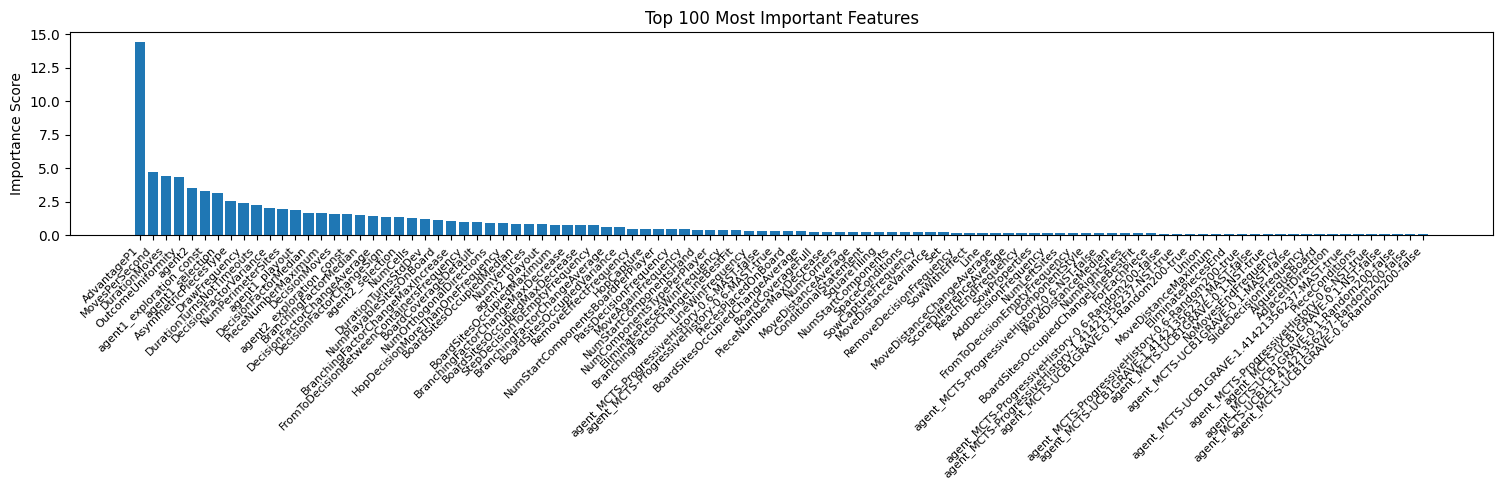

Fold 1 - RMSE: 0.4285374496474223
Fold 2


0:	learn: 0.6092873	test: 0.5710608	best: 0.5710608 (0)	total: 79.5ms	remaining: 3m 58s


50:	learn: 0.3899367	test: 0.4742302	best: 0.4742302 (50)	total: 4.83s	remaining: 4m 39s


100:	learn: 0.3522265	test: 0.4520068	best: 0.4520068 (100)	total: 9.83s	remaining: 4m 42s


150:	learn: 0.3294032	test: 0.4407221	best: 0.4407221 (150)	total: 14.9s	remaining: 4m 40s


200:	learn: 0.3130090	test: 0.4352998	best: 0.4352998 (200)	total: 19.8s	remaining: 4m 35s


250:	learn: 0.3016127	test: 0.4314751	best: 0.4314751 (250)	total: 24.8s	remaining: 4m 31s


300:	learn: 0.2925910	test: 0.4287360	best: 0.4287360 (300)	total: 29.8s	remaining: 4m 27s


350:	learn: 0.2849216	test: 0.4266663	best: 0.4266663 (350)	total: 34.9s	remaining: 4m 23s


400:	learn: 0.2784195	test: 0.4252494	best: 0.4252494 (400)	total: 39.9s	remaining: 4m 18s


450:	learn: 0.2722177	test: 0.4239325	best: 0.4239122 (449)	total: 44.9s	remaining: 4m 13s


500:	learn: 0.2672872	test: 0.4231258	best: 0.4231258 (500)	total: 50s	remaining: 4m 9s


550:	learn: 0.2625462	test: 0.4225537	best: 0.4225175 (546)	total: 55s	remaining: 4m 4s


600:	learn: 0.2583916	test: 0.4217751	best: 0.4217751 (600)	total: 1m	remaining: 3m 59s


650:	learn: 0.2545248	test: 0.4213668	best: 0.4213668 (650)	total: 1m 5s	remaining: 3m 54s


700:	learn: 0.2509342	test: 0.4205757	best: 0.4205694 (697)	total: 1m 10s	remaining: 3m 50s


750:	learn: 0.2475457	test: 0.4200555	best: 0.4200555 (750)	total: 1m 15s	remaining: 3m 45s


800:	learn: 0.2442710	test: 0.4195943	best: 0.4195943 (800)	total: 1m 20s	remaining: 3m 40s


850:	learn: 0.2415120	test: 0.4192019	best: 0.4192019 (850)	total: 1m 25s	remaining: 3m 35s


900:	learn: 0.2386431	test: 0.4188731	best: 0.4188478 (898)	total: 1m 30s	remaining: 3m 31s


950:	learn: 0.2358402	test: 0.4183874	best: 0.4183778 (948)	total: 1m 35s	remaining: 3m 26s


1000:	learn: 0.2333047	test: 0.4180629	best: 0.4180600 (991)	total: 1m 40s	remaining: 3m 21s


1050:	learn: 0.2309719	test: 0.4177827	best: 0.4177798 (1048)	total: 1m 45s	remaining: 3m 16s


1100:	learn: 0.2287726	test: 0.4175968	best: 0.4175684 (1097)	total: 1m 51s	remaining: 3m 11s


1150:	learn: 0.2265808	test: 0.4174783	best: 0.4174661 (1147)	total: 1m 56s	remaining: 3m 6s


1200:	learn: 0.2243380	test: 0.4172734	best: 0.4172711 (1199)	total: 2m 1s	remaining: 3m 1s


1250:	learn: 0.2221406	test: 0.4172769	best: 0.4172201 (1238)	total: 2m 6s	remaining: 2m 56s


1300:	learn: 0.2201108	test: 0.4170956	best: 0.4170911 (1297)	total: 2m 11s	remaining: 2m 51s


1350:	learn: 0.2181004	test: 0.4169284	best: 0.4169214 (1346)	total: 2m 16s	remaining: 2m 46s


1400:	learn: 0.2163660	test: 0.4168980	best: 0.4168351 (1370)	total: 2m 21s	remaining: 2m 41s


1450:	learn: 0.2143429	test: 0.4169094	best: 0.4168351 (1370)	total: 2m 26s	remaining: 2m 36s


1500:	learn: 0.2125082	test: 0.4166957	best: 0.4166887 (1494)	total: 2m 31s	remaining: 2m 31s


1550:	learn: 0.2107986	test: 0.4166853	best: 0.4166496 (1548)	total: 2m 37s	remaining: 2m 26s


1600:	learn: 0.2091489	test: 0.4165572	best: 0.4165493 (1598)	total: 2m 42s	remaining: 2m 21s


1650:	learn: 0.2073634	test: 0.4164472	best: 0.4164472 (1650)	total: 2m 47s	remaining: 2m 16s


1700:	learn: 0.2056557	test: 0.4161825	best: 0.4161753 (1698)	total: 2m 52s	remaining: 2m 11s


1750:	learn: 0.2041780	test: 0.4161185	best: 0.4161068 (1739)	total: 2m 57s	remaining: 2m 6s


1800:	learn: 0.2026329	test: 0.4159799	best: 0.4159758 (1799)	total: 3m 2s	remaining: 2m 1s


1850:	learn: 0.2011894	test: 0.4159186	best: 0.4158873 (1840)	total: 3m 7s	remaining: 1m 56s


1900:	learn: 0.1996964	test: 0.4159114	best: 0.4158736 (1895)	total: 3m 12s	remaining: 1m 51s


1950:	learn: 0.1982177	test: 0.4158336	best: 0.4158179 (1948)	total: 3m 17s	remaining: 1m 46s


2000:	learn: 0.1968796	test: 0.4157452	best: 0.4157444 (1997)	total: 3m 22s	remaining: 1m 41s


2050:	learn: 0.1954860	test: 0.4157481	best: 0.4157172 (2017)	total: 3m 27s	remaining: 1m 36s


2100:	learn: 0.1940841	test: 0.4156925	best: 0.4156882 (2089)	total: 3m 33s	remaining: 1m 31s


2150:	learn: 0.1926145	test: 0.4155639	best: 0.4155552 (2145)	total: 3m 38s	remaining: 1m 26s


2200:	learn: 0.1913653	test: 0.4154439	best: 0.4154439 (2200)	total: 3m 43s	remaining: 1m 20s


2250:	learn: 0.1900965	test: 0.4154016	best: 0.4153826 (2238)	total: 3m 48s	remaining: 1m 15s


2300:	learn: 0.1888903	test: 0.4153180	best: 0.4153180 (2300)	total: 3m 53s	remaining: 1m 10s


2350:	learn: 0.1877641	test: 0.4152211	best: 0.4152210 (2349)	total: 3m 58s	remaining: 1m 5s


2400:	learn: 0.1865887	test: 0.4152513	best: 0.4152155 (2364)	total: 4m 3s	remaining: 1m


2450:	learn: 0.1855215	test: 0.4152636	best: 0.4152155 (2364)	total: 4m 8s	remaining: 55.7s


2500:	learn: 0.1842513	test: 0.4152087	best: 0.4151964 (2498)	total: 4m 13s	remaining: 50.7s


2550:	learn: 0.1830236	test: 0.4152443	best: 0.4151964 (2498)	total: 4m 19s	remaining: 45.6s


2600:	learn: 0.1819603	test: 0.4152350	best: 0.4151964 (2498)	total: 4m 24s	remaining: 40.5s


2650:	learn: 0.1807801	test: 0.4151892	best: 0.4151892 (2650)	total: 4m 29s	remaining: 35.5s


2700:	learn: 0.1797200	test: 0.4152098	best: 0.4151724 (2674)	total: 4m 34s	remaining: 30.4s


2750:	learn: 0.1787434	test: 0.4151758	best: 0.4151724 (2674)	total: 4m 39s	remaining: 25.3s


2800:	learn: 0.1777267	test: 0.4151675	best: 0.4151490 (2765)	total: 4m 44s	remaining: 20.2s


2850:	learn: 0.1767327	test: 0.4151455	best: 0.4151363 (2831)	total: 4m 50s	remaining: 15.2s


2900:	learn: 0.1757115	test: 0.4151427	best: 0.4151219 (2889)	total: 4m 55s	remaining: 10.1s


2950:	learn: 0.1746992	test: 0.4151125	best: 0.4151053 (2911)	total: 5m	remaining: 4.99s


2999:	learn: 0.1738231	test: 0.4150791	best: 0.4150791 (2999)	total: 5m 5s	remaining: 0us

bestTest = 0.4150791126
bestIteration = 2999



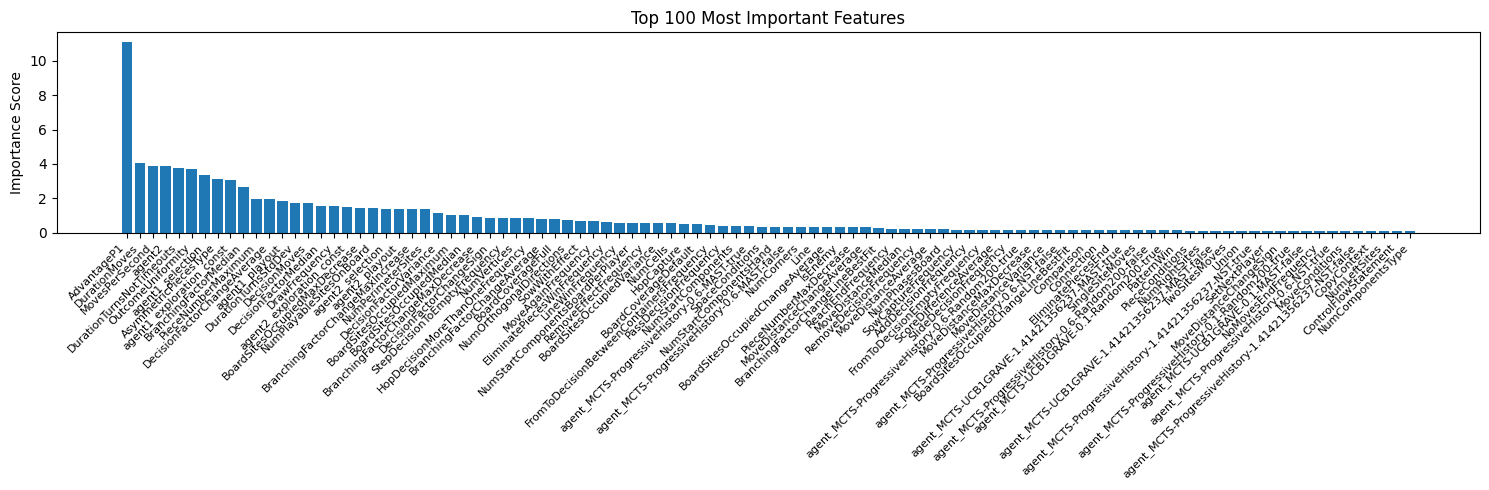

Fold 2 - RMSE: 0.41454881473088623
Fold 3


0:	learn: 0.6091914	test: 0.5704252	best: 0.5704252 (0)	total: 85.1ms	remaining: 4m 15s


50:	learn: 0.3905514	test: 0.4661074	best: 0.4661074 (50)	total: 4.7s	remaining: 4m 31s


100:	learn: 0.3489179	test: 0.4483816	best: 0.4483816 (100)	total: 9.65s	remaining: 4m 37s


150:	learn: 0.3258270	test: 0.4411240	best: 0.4411240 (150)	total: 14.5s	remaining: 4m 33s


200:	learn: 0.3109475	test: 0.4371615	best: 0.4371615 (200)	total: 19.5s	remaining: 4m 31s


250:	learn: 0.2996199	test: 0.4339524	best: 0.4339524 (250)	total: 24.4s	remaining: 4m 27s


300:	learn: 0.2909790	test: 0.4317687	best: 0.4317687 (300)	total: 29.4s	remaining: 4m 23s


350:	learn: 0.2836103	test: 0.4307457	best: 0.4307009 (343)	total: 34.3s	remaining: 4m 19s


400:	learn: 0.2771662	test: 0.4296163	best: 0.4296163 (400)	total: 39.3s	remaining: 4m 14s


450:	learn: 0.2713757	test: 0.4288810	best: 0.4288810 (450)	total: 44.2s	remaining: 4m 9s


500:	learn: 0.2662596	test: 0.4281634	best: 0.4281480 (498)	total: 49.1s	remaining: 4m 4s


550:	learn: 0.2613460	test: 0.4275290	best: 0.4274257 (549)	total: 54s	remaining: 4m


600:	learn: 0.2569015	test: 0.4266699	best: 0.4266699 (600)	total: 58.9s	remaining: 3m 55s


650:	learn: 0.2527628	test: 0.4258826	best: 0.4258373 (646)	total: 1m 3s	remaining: 3m 50s


700:	learn: 0.2486898	test: 0.4254138	best: 0.4254003 (699)	total: 1m 8s	remaining: 3m 45s


750:	learn: 0.2451297	test: 0.4247723	best: 0.4247723 (750)	total: 1m 13s	remaining: 3m 40s


800:	learn: 0.2419677	test: 0.4244103	best: 0.4243834 (798)	total: 1m 18s	remaining: 3m 36s


850:	learn: 0.2389431	test: 0.4242572	best: 0.4242572 (850)	total: 1m 23s	remaining: 3m 31s


900:	learn: 0.2358530	test: 0.4238050	best: 0.4237981 (889)	total: 1m 28s	remaining: 3m 26s


950:	learn: 0.2331866	test: 0.4236547	best: 0.4236386 (948)	total: 1m 33s	remaining: 3m 21s


1000:	learn: 0.2303920	test: 0.4236305	best: 0.4235694 (953)	total: 1m 38s	remaining: 3m 16s


1050:	learn: 0.2279620	test: 0.4233836	best: 0.4233404 (1044)	total: 1m 43s	remaining: 3m 11s


1100:	learn: 0.2255785	test: 0.4233922	best: 0.4233062 (1073)	total: 1m 48s	remaining: 3m 7s


1150:	learn: 0.2233377	test: 0.4233157	best: 0.4232907 (1137)	total: 1m 53s	remaining: 3m 2s


1200:	learn: 0.2212386	test: 0.4231401	best: 0.4230409 (1189)	total: 1m 58s	remaining: 2m 57s


1250:	learn: 0.2191524	test: 0.4229307	best: 0.4229307 (1250)	total: 2m 3s	remaining: 2m 52s


1300:	learn: 0.2171615	test: 0.4227924	best: 0.4227619 (1290)	total: 2m 8s	remaining: 2m 47s


1350:	learn: 0.2153338	test: 0.4225254	best: 0.4225254 (1350)	total: 2m 13s	remaining: 2m 42s


1400:	learn: 0.2134174	test: 0.4224865	best: 0.4224540 (1377)	total: 2m 18s	remaining: 2m 37s


1450:	learn: 0.2113890	test: 0.4223817	best: 0.4223817 (1450)	total: 2m 23s	remaining: 2m 32s


1500:	learn: 0.2095062	test: 0.4223609	best: 0.4223609 (1500)	total: 2m 28s	remaining: 2m 27s


1550:	learn: 0.2077819	test: 0.4222166	best: 0.4222044 (1542)	total: 2m 33s	remaining: 2m 23s


1600:	learn: 0.2060924	test: 0.4221214	best: 0.4220932 (1589)	total: 2m 38s	remaining: 2m 18s


1650:	learn: 0.2044011	test: 0.4219790	best: 0.4219790 (1650)	total: 2m 43s	remaining: 2m 13s


1700:	learn: 0.2028169	test: 0.4219690	best: 0.4219521 (1696)	total: 2m 48s	remaining: 2m 8s


1750:	learn: 0.2011347	test: 0.4219031	best: 0.4219022 (1733)	total: 2m 53s	remaining: 2m 3s


1800:	learn: 0.1995601	test: 0.4219328	best: 0.4218994 (1751)	total: 2m 58s	remaining: 1m 58s


1850:	learn: 0.1980058	test: 0.4217582	best: 0.4217582 (1850)	total: 3m 3s	remaining: 1m 53s


1900:	learn: 0.1966892	test: 0.4215773	best: 0.4215692 (1895)	total: 3m 8s	remaining: 1m 48s


1950:	learn: 0.1953004	test: 0.4214722	best: 0.4214590 (1943)	total: 3m 13s	remaining: 1m 43s


2000:	learn: 0.1938939	test: 0.4213911	best: 0.4213861 (1991)	total: 3m 18s	remaining: 1m 38s


2050:	learn: 0.1925758	test: 0.4213911	best: 0.4213474 (2039)	total: 3m 23s	remaining: 1m 33s


2100:	learn: 0.1914077	test: 0.4212951	best: 0.4212940 (2095)	total: 3m 28s	remaining: 1m 29s


2150:	learn: 0.1899644	test: 0.4212975	best: 0.4211777 (2116)	total: 3m 33s	remaining: 1m 24s


2200:	learn: 0.1886736	test: 0.4212057	best: 0.4211777 (2116)	total: 3m 37s	remaining: 1m 19s


2250:	learn: 0.1874443	test: 0.4210965	best: 0.4210789 (2240)	total: 3m 43s	remaining: 1m 14s


2300:	learn: 0.1861408	test: 0.4210067	best: 0.4209948 (2299)	total: 3m 47s	remaining: 1m 9s


2350:	learn: 0.1849521	test: 0.4208663	best: 0.4208663 (2350)	total: 3m 53s	remaining: 1m 4s


2400:	learn: 0.1836441	test: 0.4208615	best: 0.4208299 (2375)	total: 3m 57s	remaining: 59.4s


2450:	learn: 0.1823892	test: 0.4207749	best: 0.4207710 (2448)	total: 4m 2s	remaining: 54.4s


2500:	learn: 0.1812950	test: 0.4207304	best: 0.4207292 (2499)	total: 4m 7s	remaining: 49.5s


2550:	learn: 0.1801509	test: 0.4207174	best: 0.4207174 (2550)	total: 4m 12s	remaining: 44.5s


2600:	learn: 0.1791063	test: 0.4206593	best: 0.4206593 (2600)	total: 4m 17s	remaining: 39.6s


2650:	learn: 0.1779795	test: 0.4206420	best: 0.4206132 (2616)	total: 4m 22s	remaining: 34.6s


2700:	learn: 0.1769255	test: 0.4205719	best: 0.4205719 (2700)	total: 4m 27s	remaining: 29.7s


2750:	learn: 0.1759175	test: 0.4205641	best: 0.4205408 (2718)	total: 4m 32s	remaining: 24.7s


2800:	learn: 0.1748126	test: 0.4206012	best: 0.4205346 (2775)	total: 4m 37s	remaining: 19.7s


2850:	learn: 0.1737608	test: 0.4206058	best: 0.4205346 (2775)	total: 4m 42s	remaining: 14.8s


2900:	learn: 0.1725650	test: 0.4205983	best: 0.4205346 (2775)	total: 4m 47s	remaining: 9.82s


2950:	learn: 0.1715661	test: 0.4205829	best: 0.4205346 (2775)	total: 4m 52s	remaining: 4.86s


2999:	learn: 0.1705541	test: 0.4205709	best: 0.4205346 (2775)	total: 4m 57s	remaining: 0us

bestTest = 0.4205345854
bestIteration = 2775

Shrink model to first 2776 iterations.


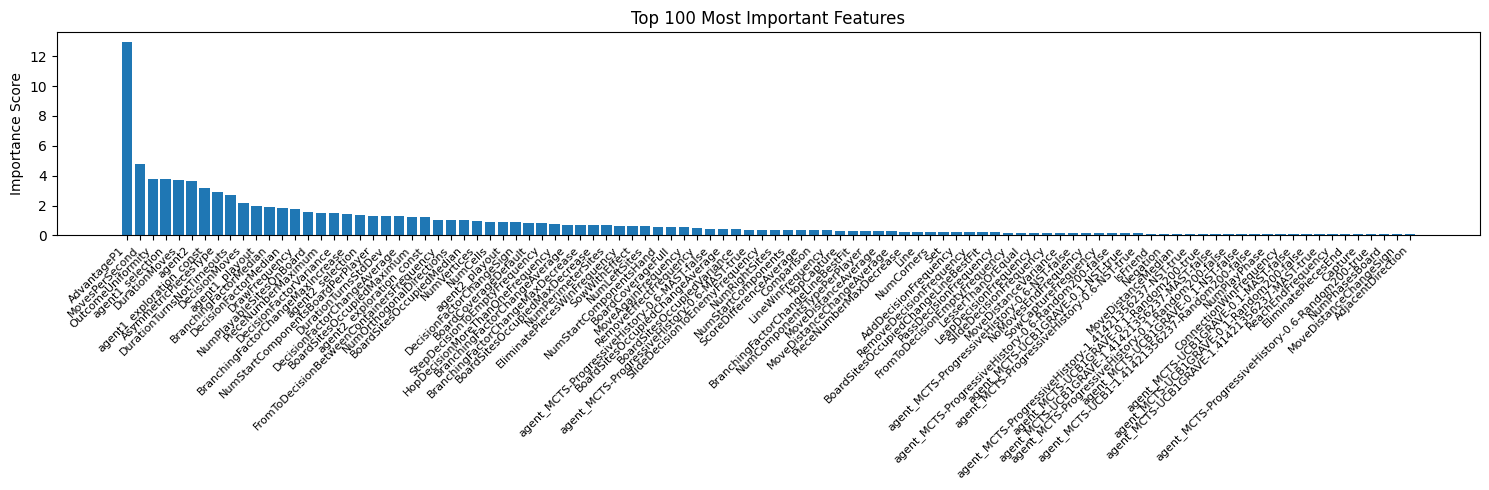

Fold 3 - RMSE: 0.4201195329589341
Fold 4


0:	learn: 0.6100362	test: 0.5668661	best: 0.5668661 (0)	total: 84.3ms	remaining: 4m 12s


50:	learn: 0.3855773	test: 0.4555858	best: 0.4555858 (50)	total: 4.66s	remaining: 4m 29s


100:	learn: 0.3485289	test: 0.4418112	best: 0.4418112 (100)	total: 9.66s	remaining: 4m 37s


150:	learn: 0.3266913	test: 0.4345375	best: 0.4345375 (150)	total: 14.5s	remaining: 4m 33s


200:	learn: 0.3112506	test: 0.4309815	best: 0.4309559 (199)	total: 19.4s	remaining: 4m 30s


250:	learn: 0.3002839	test: 0.4288633	best: 0.4288633 (250)	total: 24.4s	remaining: 4m 27s


300:	learn: 0.2916670	test: 0.4273519	best: 0.4273508 (299)	total: 29.4s	remaining: 4m 23s


350:	learn: 0.2838612	test: 0.4263429	best: 0.4263429 (350)	total: 34.3s	remaining: 4m 19s


400:	learn: 0.2770333	test: 0.4253872	best: 0.4253872 (400)	total: 39.3s	remaining: 4m 14s


450:	learn: 0.2708979	test: 0.4249783	best: 0.4249783 (450)	total: 44.2s	remaining: 4m 10s


500:	learn: 0.2657593	test: 0.4241631	best: 0.4241631 (500)	total: 49.2s	remaining: 4m 5s


550:	learn: 0.2612598	test: 0.4235532	best: 0.4235532 (550)	total: 54.1s	remaining: 4m


600:	learn: 0.2566516	test: 0.4232946	best: 0.4232195 (592)	total: 59.1s	remaining: 3m 55s


650:	learn: 0.2525726	test: 0.4227084	best: 0.4227084 (650)	total: 1m 4s	remaining: 3m 50s


700:	learn: 0.2488590	test: 0.4226095	best: 0.4225527 (659)	total: 1m 8s	remaining: 3m 46s


750:	learn: 0.2453671	test: 0.4221342	best: 0.4221342 (750)	total: 1m 13s	remaining: 3m 41s


800:	learn: 0.2421206	test: 0.4217947	best: 0.4217947 (800)	total: 1m 18s	remaining: 3m 36s


850:	learn: 0.2390306	test: 0.4216012	best: 0.4215181 (838)	total: 1m 23s	remaining: 3m 31s


900:	learn: 0.2361924	test: 0.4214785	best: 0.4214025 (888)	total: 1m 28s	remaining: 3m 26s


950:	learn: 0.2334550	test: 0.4212852	best: 0.4212852 (950)	total: 1m 33s	remaining: 3m 21s


1000:	learn: 0.2311105	test: 0.4212019	best: 0.4211865 (964)	total: 1m 38s	remaining: 3m 17s


1050:	learn: 0.2288381	test: 0.4208250	best: 0.4207961 (1048)	total: 1m 43s	remaining: 3m 12s


1100:	learn: 0.2267302	test: 0.4206518	best: 0.4206431 (1099)	total: 1m 48s	remaining: 3m 7s


1150:	learn: 0.2244423	test: 0.4204465	best: 0.4204151 (1147)	total: 1m 53s	remaining: 3m 2s


1200:	learn: 0.2222913	test: 0.4203529	best: 0.4203167 (1191)	total: 1m 58s	remaining: 2m 57s


1250:	learn: 0.2203547	test: 0.4201767	best: 0.4201552 (1240)	total: 2m 3s	remaining: 2m 53s


1300:	learn: 0.2183690	test: 0.4200624	best: 0.4200622 (1299)	total: 2m 8s	remaining: 2m 48s


1350:	learn: 0.2166158	test: 0.4200214	best: 0.4199897 (1319)	total: 2m 13s	remaining: 2m 43s


1400:	learn: 0.2148407	test: 0.4198607	best: 0.4198607 (1400)	total: 2m 18s	remaining: 2m 38s


1450:	learn: 0.2130886	test: 0.4197597	best: 0.4197597 (1450)	total: 2m 23s	remaining: 2m 33s


1500:	learn: 0.2113247	test: 0.4196641	best: 0.4196618 (1499)	total: 2m 28s	remaining: 2m 28s


1550:	learn: 0.2096463	test: 0.4194593	best: 0.4194593 (1550)	total: 2m 33s	remaining: 2m 23s


1600:	learn: 0.2079656	test: 0.4194004	best: 0.4193954 (1599)	total: 2m 38s	remaining: 2m 18s


1650:	learn: 0.2064273	test: 0.4194064	best: 0.4193817 (1610)	total: 2m 43s	remaining: 2m 13s


1700:	learn: 0.2048740	test: 0.4193865	best: 0.4193538 (1671)	total: 2m 49s	remaining: 2m 9s


1750:	learn: 0.2033812	test: 0.4193098	best: 0.4192979 (1745)	total: 2m 54s	remaining: 2m 4s


1800:	learn: 0.2017602	test: 0.4193657	best: 0.4192910 (1753)	total: 2m 59s	remaining: 1m 59s


1850:	learn: 0.2002074	test: 0.4193612	best: 0.4192910 (1753)	total: 3m 4s	remaining: 1m 54s


1900:	learn: 0.1988189	test: 0.4193137	best: 0.4192910 (1753)	total: 3m 9s	remaining: 1m 49s


1950:	learn: 0.1974861	test: 0.4191855	best: 0.4191855 (1950)	total: 3m 14s	remaining: 1m 44s


2000:	learn: 0.1960902	test: 0.4191565	best: 0.4191306 (1969)	total: 3m 19s	remaining: 1m 39s


2050:	learn: 0.1947258	test: 0.4191219	best: 0.4191219 (2050)	total: 3m 24s	remaining: 1m 34s


2100:	learn: 0.1933981	test: 0.4191103	best: 0.4190922 (2085)	total: 3m 29s	remaining: 1m 29s


2150:	learn: 0.1921574	test: 0.4191512	best: 0.4190871 (2113)	total: 3m 34s	remaining: 1m 24s


2200:	learn: 0.1908278	test: 0.4190619	best: 0.4190572 (2181)	total: 3m 39s	remaining: 1m 19s


2250:	learn: 0.1895926	test: 0.4190486	best: 0.4190289 (2237)	total: 3m 44s	remaining: 1m 14s


2300:	learn: 0.1884004	test: 0.4190305	best: 0.4190235 (2264)	total: 3m 49s	remaining: 1m 9s


2350:	learn: 0.1871492	test: 0.4190610	best: 0.4190229 (2301)	total: 3m 54s	remaining: 1m 4s


2400:	learn: 0.1859498	test: 0.4190146	best: 0.4190146 (2400)	total: 3m 59s	remaining: 59.7s


2450:	learn: 0.1848520	test: 0.4190312	best: 0.4189793 (2440)	total: 4m 4s	remaining: 54.8s


2500:	learn: 0.1837285	test: 0.4190403	best: 0.4189793 (2440)	total: 4m 9s	remaining: 49.8s


2550:	learn: 0.1825456	test: 0.4189693	best: 0.4189684 (2548)	total: 4m 14s	remaining: 44.8s


2600:	learn: 0.1814777	test: 0.4190203	best: 0.4189684 (2548)	total: 4m 19s	remaining: 39.8s


2650:	learn: 0.1803744	test: 0.4189618	best: 0.4189618 (2650)	total: 4m 24s	remaining: 34.9s


2700:	learn: 0.1791809	test: 0.4189466	best: 0.4189442 (2694)	total: 4m 29s	remaining: 29.9s


2750:	learn: 0.1781468	test: 0.4189483	best: 0.4189320 (2723)	total: 4m 34s	remaining: 24.9s


2800:	learn: 0.1771524	test: 0.4189301	best: 0.4189208 (2798)	total: 4m 39s	remaining: 19.9s


2850:	learn: 0.1761597	test: 0.4189253	best: 0.4189208 (2798)	total: 4m 44s	remaining: 14.9s


2900:	learn: 0.1751434	test: 0.4188695	best: 0.4188602 (2872)	total: 4m 50s	remaining: 9.9s


2950:	learn: 0.1741267	test: 0.4188884	best: 0.4188602 (2872)	total: 4m 55s	remaining: 4.9s


2999:	learn: 0.1731407	test: 0.4189364	best: 0.4188602 (2872)	total: 5m	remaining: 0us

bestTest = 0.4188602296
bestIteration = 2872

Shrink model to first 2873 iterations.


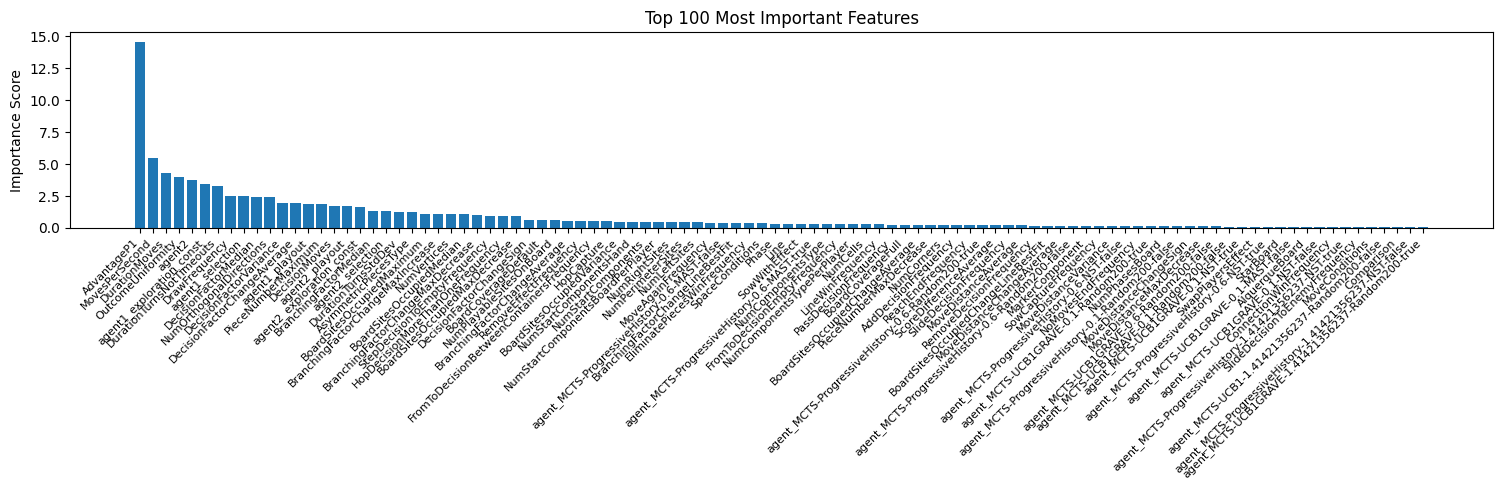

Fold 4 - RMSE: 0.41809153329008303
Fold 5


0:	learn: 0.6073019	test: 0.5811280	best: 0.5811280 (0)	total: 70.6ms	remaining: 3m 31s


50:	learn: 0.3863189	test: 0.4637836	best: 0.4637836 (50)	total: 4.84s	remaining: 4m 39s


100:	learn: 0.3493465	test: 0.4449062	best: 0.4449062 (100)	total: 9.88s	remaining: 4m 43s


150:	learn: 0.3276219	test: 0.4357997	best: 0.4357997 (150)	total: 15s	remaining: 4m 42s


200:	learn: 0.3130857	test: 0.4303826	best: 0.4303497 (199)	total: 20.1s	remaining: 4m 39s


250:	learn: 0.3014432	test: 0.4271369	best: 0.4271369 (250)	total: 25.2s	remaining: 4m 35s


300:	learn: 0.2917122	test: 0.4251846	best: 0.4251797 (297)	total: 30.2s	remaining: 4m 30s


350:	learn: 0.2840274	test: 0.4242747	best: 0.4242535 (337)	total: 35.3s	remaining: 4m 26s


400:	learn: 0.2775573	test: 0.4231703	best: 0.4231323 (396)	total: 40.4s	remaining: 4m 21s


450:	learn: 0.2716864	test: 0.4219630	best: 0.4219513 (448)	total: 45.5s	remaining: 4m 17s


500:	learn: 0.2661598	test: 0.4213560	best: 0.4213355 (499)	total: 50.6s	remaining: 4m 12s


550:	learn: 0.2611460	test: 0.4205196	best: 0.4205196 (550)	total: 55.7s	remaining: 4m 7s


600:	learn: 0.2569913	test: 0.4198722	best: 0.4198716 (598)	total: 1m	remaining: 4m 2s


650:	learn: 0.2528605	test: 0.4194242	best: 0.4194242 (650)	total: 1m 5s	remaining: 3m 57s


700:	learn: 0.2489436	test: 0.4192634	best: 0.4192341 (691)	total: 1m 10s	remaining: 3m 52s


750:	learn: 0.2456967	test: 0.4190884	best: 0.4190884 (750)	total: 1m 16s	remaining: 3m 47s


800:	learn: 0.2423436	test: 0.4188900	best: 0.4188287 (795)	total: 1m 21s	remaining: 3m 42s


850:	learn: 0.2394238	test: 0.4185991	best: 0.4185761 (844)	total: 1m 26s	remaining: 3m 37s


900:	learn: 0.2365693	test: 0.4184256	best: 0.4183896 (886)	total: 1m 31s	remaining: 3m 33s


950:	learn: 0.2335468	test: 0.4181588	best: 0.4181588 (950)	total: 1m 36s	remaining: 3m 28s


1000:	learn: 0.2311752	test: 0.4179797	best: 0.4179797 (1000)	total: 1m 41s	remaining: 3m 23s


1050:	learn: 0.2286935	test: 0.4179969	best: 0.4179017 (1043)	total: 1m 47s	remaining: 3m 18s


1100:	learn: 0.2263776	test: 0.4178581	best: 0.4178446 (1097)	total: 1m 52s	remaining: 3m 13s


1150:	learn: 0.2242268	test: 0.4177329	best: 0.4177329 (1150)	total: 1m 57s	remaining: 3m 8s


1200:	learn: 0.2220780	test: 0.4175124	best: 0.4175086 (1198)	total: 2m 2s	remaining: 3m 3s


1250:	learn: 0.2200874	test: 0.4173407	best: 0.4173407 (1250)	total: 2m 7s	remaining: 2m 58s


1300:	learn: 0.2181940	test: 0.4172582	best: 0.4172186 (1296)	total: 2m 12s	remaining: 2m 53s


1350:	learn: 0.2162995	test: 0.4172084	best: 0.4171982 (1331)	total: 2m 18s	remaining: 2m 48s


1400:	learn: 0.2144552	test: 0.4171262	best: 0.4171075 (1395)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2127020	test: 0.4172195	best: 0.4171006 (1401)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2110278	test: 0.4172170	best: 0.4171006 (1401)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.2093086	test: 0.4172309	best: 0.4171006 (1401)	total: 2m 38s	remaining: 2m 28s


1600:	learn: 0.2075205	test: 0.4170197	best: 0.4170197 (1600)	total: 2m 43s	remaining: 2m 23s


1650:	learn: 0.2058687	test: 0.4169243	best: 0.4169048 (1646)	total: 2m 48s	remaining: 2m 17s


1700:	learn: 0.2043470	test: 0.4168290	best: 0.4168290 (1700)	total: 2m 54s	remaining: 2m 12s


1750:	learn: 0.2026700	test: 0.4167005	best: 0.4167005 (1750)	total: 2m 59s	remaining: 2m 7s


1800:	learn: 0.2011827	test: 0.4166857	best: 0.4166244 (1771)	total: 3m 4s	remaining: 2m 2s


1850:	learn: 0.1995569	test: 0.4166230	best: 0.4166118 (1835)	total: 3m 9s	remaining: 1m 57s


1900:	learn: 0.1980593	test: 0.4167376	best: 0.4166118 (1835)	total: 3m 14s	remaining: 1m 52s


1950:	learn: 0.1967478	test: 0.4167332	best: 0.4166118 (1835)	total: 3m 19s	remaining: 1m 47s


2000:	learn: 0.1953500	test: 0.4166840	best: 0.4166118 (1835)	total: 3m 24s	remaining: 1m 42s


2050:	learn: 0.1938705	test: 0.4166525	best: 0.4166118 (1835)	total: 3m 29s	remaining: 1m 37s


2100:	learn: 0.1926007	test: 0.4165474	best: 0.4165405 (2098)	total: 3m 35s	remaining: 1m 32s


2150:	learn: 0.1912951	test: 0.4164921	best: 0.4164908 (2149)	total: 3m 40s	remaining: 1m 26s


2200:	learn: 0.1898805	test: 0.4166167	best: 0.4164908 (2149)	total: 3m 45s	remaining: 1m 21s


2250:	learn: 0.1885641	test: 0.4166426	best: 0.4164908 (2149)	total: 3m 50s	remaining: 1m 16s


2300:	learn: 0.1873745	test: 0.4166267	best: 0.4164908 (2149)	total: 3m 55s	remaining: 1m 11s


2350:	learn: 0.1861704	test: 0.4166048	best: 0.4164908 (2149)	total: 4m 1s	remaining: 1m 6s


2400:	learn: 0.1849858	test: 0.4165206	best: 0.4164908 (2149)	total: 4m 6s	remaining: 1m 1s


2450:	learn: 0.1836455	test: 0.4165501	best: 0.4164908 (2149)	total: 4m 11s	remaining: 56.3s


2500:	learn: 0.1825135	test: 0.4164937	best: 0.4164891 (2491)	total: 4m 16s	remaining: 51.2s


2550:	learn: 0.1813602	test: 0.4164427	best: 0.4164287 (2536)	total: 4m 21s	remaining: 46.1s


2600:	learn: 0.1802264	test: 0.4164190	best: 0.4164065 (2589)	total: 4m 26s	remaining: 40.9s


2650:	learn: 0.1790742	test: 0.4163732	best: 0.4163732 (2650)	total: 4m 31s	remaining: 35.8s


2700:	learn: 0.1780718	test: 0.4163861	best: 0.4163650 (2660)	total: 4m 37s	remaining: 30.7s


2750:	learn: 0.1769420	test: 0.4163231	best: 0.4163201 (2747)	total: 4m 42s	remaining: 25.6s


2800:	learn: 0.1758499	test: 0.4163715	best: 0.4163201 (2747)	total: 4m 47s	remaining: 20.4s


2850:	learn: 0.1747791	test: 0.4164582	best: 0.4163201 (2747)	total: 4m 52s	remaining: 15.3s


2900:	learn: 0.1737209	test: 0.4163925	best: 0.4163201 (2747)	total: 4m 57s	remaining: 10.2s


2950:	learn: 0.1728877	test: 0.4164145	best: 0.4163201 (2747)	total: 5m 2s	remaining: 5.03s


2999:	learn: 0.1718486	test: 0.4164561	best: 0.4163201 (2747)	total: 5m 8s	remaining: 0us

bestTest = 0.4163200719
bestIteration = 2747

Shrink model to first 2748 iterations.


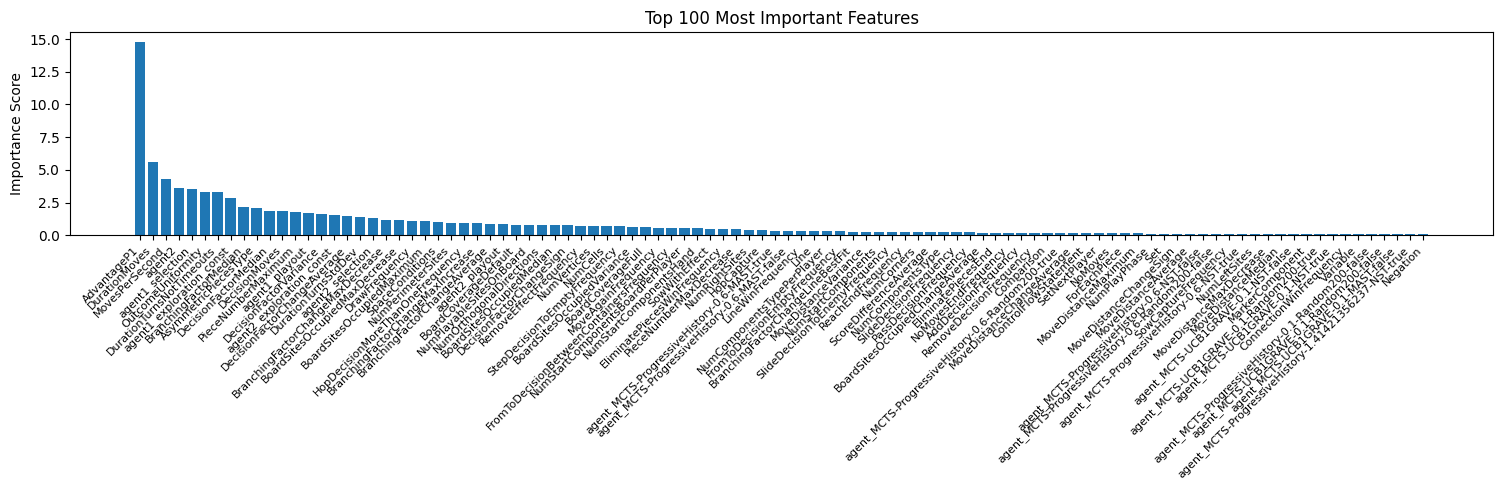

Fold 5 - RMSE: 0.4157310478710102
List of oof scores: [0.4285374496474223, 0.41454881473088623, 0.4201195329589341, 0.41809153329008303, 0.4157310478710102]
Average oof score: 0.41940567569966714


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4266
Score: 0.4360
Score: 0.4243
Score: 0.4333
Score: 0.4060
Average CV1 Score: 0.4253

CV2 OOF Scores:
Score: 0.4164
Score: 0.3990
Score: 0.4289
Score: 0.4390
Score: 0.4249
Average CV2 Score: 0.4216

CV3 OOF Scores:
Score: 0.4285
Score: 0.4145
Score: 0.4201
Score: 0.4181
Score: 0.4157
Average CV3 Score: 0.4194


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

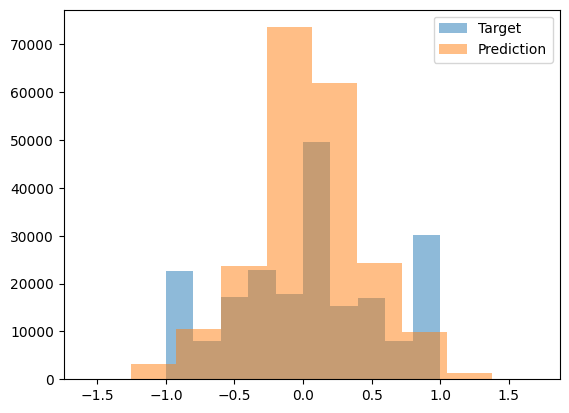

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.122234       │
│ 233235 ┆ -0.183565      │
│ 233236 ┆ -0.03396       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***